In [1]:
from typing import Iterator, List, Dict, Optional, cast
import torch
import torch.optim as optim
from torch.nn import MSELoss
from torch.nn import functional as F
from torch.nn import ModuleList

import numpy as np
from allennlp.data import Instance
from allennlp.data.fields import TextField, LabelField, SequenceLabelField, ArrayField, MetadataField, ListField
from allennlp.data.dataset_readers import DatasetReader
from allennlp.common.file_utils import cached_path
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data.tokenizers import Token
from allennlp.data.vocabulary import Vocabulary
from allennlp.data.batch import Batch
from allennlp.models import Model
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding, TokenEmbedder
from allennlp.modules.token_embedders.pretrained_transformer_embedder import PretrainedTransformerEmbedder
from allennlp.modules.token_embedders.pretrained_transformer_mismatched_embedder import PretrainedTransformerMismatchedEmbedder
# from allennlp.modules.seq2seq_encoders.multi_head_self_attention import MultiHeadSelfAttention
from allennlp.modules.seq2seq_encoders import Seq2SeqEncoder, PytorchSeq2SeqWrapper
from allennlp.modules.seq2vec_encoders import Seq2VecEncoder, PytorchSeq2VecWrapper
from allennlp.modules.seq2vec_encoders.cnn_encoder import CnnEncoder
from allennlp.modules.attention import Attention
from allennlp.modules.matrix_attention.matrix_attention import MatrixAttention
from allennlp.modules.matrix_attention.linear_matrix_attention import LinearMatrixAttention
from allennlp.modules.matrix_attention.cosine_matrix_attention import CosineMatrixAttention
from allennlp.modules.matrix_attention.bilinear_matrix_attention import BilinearMatrixAttention

from allennlp.modules.conditional_random_field import allowed_transitions, ConditionalRandomField

from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits, \
    get_device_of, masked_softmax, weighted_sum, \
    get_mask_from_sequence_lengths, get_lengths_from_binary_sequence_mask, tensors_equal

from allennlp.training.metrics import BooleanAccuracy, CategoricalAccuracy, MeanAbsoluteError, Average, BLEU
from allennlp.data.samplers import BucketBatchSampler
from allennlp.data.dataloader import DataLoader, PyTorchDataLoader
from allennlp.training.trainer import GradientDescentTrainer
# from allennlp.predictors import Predictor, Seq2SeqPredictor, SimpleSeq2SeqPredictor, SentenceTaggerPredictor
from allennlp.predictors import Predictor, SentenceTaggerPredictor
from allennlp.nn.activations import Activation
from allennlp.common.tqdm import Tqdm
from allennlp.common.params import Params
from allennlp.common.util import JsonDict, sanitize

from allennlp_models.generation.predictors import Seq2SeqPredictor
from allennlp_models.generation.models.simple_seq2seq import SimpleSeq2Seq
from allennlp_models.generation.modules.seq_decoders.seq_decoder import SeqDecoder
from allennlp_models.generation.modules.decoder_nets.decoder_net import DecoderNet


# from spacy.tokenizer import Tokenizer as SpacyTokenizer
# from spacy.lang.en import English
# nlp = English()
# Create a blank Tokenizer with just the English vocab
# tokenizer = Tokenizer(nlp.vocab)

from tqdm.notebook import tqdm

from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures

import os, sys
import itertools
import json
from collections import defaultdict, Counter
from inspect import signature
import warnings
import pickle
from copy import copy, deepcopy
from overrides import overrides
import importlib
import string
import re
import matplotlib.pyplot as plt
import editdistance
from copy import copy, deepcopy
import random
import nltk

from transformers import BertPreTrainedModel, BertModel, BertConfig, BertTokenizer

from utils.spider import process_sql, evaluation
from utils.schema_gnn.spider_utils import Table, TableColumn, read_dataset_schema
from utils.misc_utils import Load_CMU_Dict, WordPronDist, WordPronSimilarity, ConstructWordSimMatrix

import dataset_readers
import models
import predictors

from dataset_readers.reader_utils import extractAudioFeatures, extractAudioFeatures_NoPooling, dbToTokens, \
    text_cell_to_toks
from modules.encoder import SpeakQLEncoder, SpeakQLEncoderV1
# from modules.encoder import SpeakQLEncoder, SpeakQLEncoderV1, SpeakQLEncoder_Gated_Fusion
# from models.reranker import SpiderASRRerankerV0, SpiderASRRerankerV1, SpiderASRRerankerV2, SpiderASRReranker_Siamese
# from predictors.reranker_predictor import SpiderASRRerankerPredictor, SpiderASRRerankerPredictor_Siamese

from dataset_readers import SpiderASRRerankerReaderV2_Siamese_Combined
from dataset_readers import SpiderASRRewriterReader_Seq2seq_Combined_new, \
    SpiderASRRewriterReader_Tagger_Combined_new, SpiderASRRewriterReader_ILM_Combined_new
from models import SpiderASRRewriter_Tagger_Combined_new, SpiderASRRewriter_ILM_Combined_new, \
    SpiderASRRewriter_Seq2seq_Combined_new
#     SpiderASRRewriter_Tagger_Combined_legacy, SpiderASRRewriter_ILM_Combined_legacy
from predictors import SpiderASRRewriterPredictor_Tagger, SpiderASRRewriterPredictor_ILM, SpiderASRRewriterPredictor_Seq2seq

from others.wer import WordErrorRate

from sklearn.metrics import pairwise

torch.manual_seed(1)

In [2]:
# import models, modules
# importlib.reload(models)
# from models import rewriter_ILM_comb_new
# importlib.reload(modules)
# from modules import copynet_decoder

### Loading dataset_reader and model

In [64]:
full_config = Params.from_file('train_configs/rewriter_2.31.0.0i.jsonnet')

In [65]:
dsreader_config = deepcopy(full_config['dataset_reader'])
dsreader_config['databases_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database"
dsreader_config['dataset_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my"
dsreader_config['tables_json_fname'] = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/tables.json'
dsreader_config['tabert_model_path'] = '/Users/mac/Desktop/syt/Deep-Learning/Repos/TaBERT/pretrained-models/tabert_base_k1/model.bin'
dsreader_config['pronun_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/CMUdict/cmudict-0.7b.txt"
dsreader_config['db_tok2phs_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my/db/db_tok2phs.json"
# dsreader_config['samples_limit'] = 50
dsreader_config['cands_limit'] = 1
dsreader_config.as_dict()


{'databases_dir': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database',
 'dataset_dir': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my',
 'db_cells_in_bracket': True,
 'db_tok2phs_dict_path': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my/db/db_tok2phs.json',
 'include_align_tags': True,
 'include_gold_rewrite_seq': True,
 'max_sequence_len': 300,
 'ph_token_indexers': {'phonemes': {'namespace': 'phonemes',
   'type': 'single_id'}},
 'pronun_dict_path': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/CMUdict/cmudict-0.7b.txt',
 'specify_full_path': False,
 'src_token_indexers': {'bert': {'model_name': 'facebook/bart-base',
   'type': 'pretrained_transformer_mismatched'},
  'char': {'min_padding_length': 5,
   'namespace': 'token_characters',
   'type': 'characters'}},
 'tabert_model_path': '/Users/mac/Desktop/syt/Deep-Learning/Repos/TaBERT/pretrained-models/tabert_base_k1/model.bin',
 'tables_json_fname': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/ta

In [66]:
dataset_reader = DatasetReader.from_params(dsreader_config)

Loading CMU Dict done: 133854 entries, 125074 words, 113745 prons
Loading db_tok2phs Dict done: 102186 entries, 102186 words, 91693 prons
Joint word2pron size = 202111
[('hellenizing', {('HH', 'EH', 'L', 'AH', 'N', 'AY', 'Z', 'IH', 'NG')}), ('kinsella', {('K', 'IY', 'N', 'S', 'EH', 'L', 'AH')}), ('matsch', {('M', 'AE', 'CH')}), ('odonnel', {('OW', 'D', 'AA', 'N', 'AH', 'L')}), ('quads', {('K', 'W', 'AA', 'D', 'Z')}), ("sears'", {('S', 'IH', 'R', 'Z')})]


In [67]:
# tables_json_fname = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/tables.json'
# dataset_dir = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my'
# databases_dir = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database'

# cmudict_path = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/CMUdict/cmudict-0.7b.txt'


# src_token_indexers = {
#     'bert': TokenIndexer.by_name('pretrained_transformer_mismatched')('bert-base-uncased'),
#     "char": TokenIndexer.by_name('characters')(namespace="token_characters", min_padding_length=5)
# }
# tgt_token_indexers = {'tgt_tokens': SingleIdTokenIndexer(namespace='tgt_tokens')}

# dataset_reader = SpiderASRRewriterReader_ILM_Combined(tables_json_fname=tables_json_fname,
#                                                     dataset_dir=dataset_dir,
#                                                     databases_dir=databases_dir,
#                                                     src_token_indexers=src_token_indexers,
#                                                     tgt_token_indexers=tgt_token_indexers,
#                                                     include_align_tags=True,
#                                                     pronun_dict_path=cmudict_path,
#                                                     samples_limit=10)



In [68]:
test_dataset = dataset_reader.read('test')
len(test_dataset)

Loading literals failed: wta_1::players
['first_name', 'last_name', 'hand', 'country_code']
Could not decode to UTF-8 column 'last_name' with text 'Treyes Albarrac��N'
Question OOV: 65, [('airlinesflights', ['EH', 'R', 'L', 'AY', 'N', 'S', 'F', 'L', 'AY', 'T', 'S']), ('liste', ['L', 'IH', 'S', 'T']), ('lexs', ['L', 'EH', 'K', 'S', 'Z']), ('cdo', ['S', 'IY', 'D', 'IY', 'OW']), ('dolo', ['D', 'OW', 'L', 'OW']), ('roomba', ['R', 'UW', 'M', 'B', 'AX']), ('shou', ['SH', 'UW']), ('everdeen', ['EH', 'V', 'ER', 'D', 'IY', 'N']), ('happend', ['HH', 'AE', 'P', 'AX', 'N', 'D']), ('witha', ['W', 'IH', 'DH', 'AE'])]


547

In [31]:
original_dev_path = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/dev.json'
with open(original_dev_path, 'r') as f:
    original_dev_dataset = json.load(f)
len(original_dev_dataset)

1034

In [12]:
# tagger_ILM_model = Model.from_archive('runs/2.0.1/model.tar.gz')
ILM_model = Model.from_archive('runs/2.31.0.2i/model.tar.gz')

self._start_index: 3, @start@
self._end_index: 4, @end@
self._pad_index: 0, @@PADDING@@


In [13]:
ILM_model

SpiderASRRewriter_ILM_Combined_new(
  (src_text_embedder): BasicTextFieldEmbedder(
    (token_embedder_bert): PretrainedTransformerMismatchedEmbedder_Patched(
      (_matched_embedder): PretrainedTransformerEmbedder_Patched(
        (transformer_model): BartEncoder(
          (embed_tokens): Embedding(50265, 768, padding_idx=1)
          (embed_positions): LearnedPositionalEmbedding(1026, 768, padding_idx=1)
          (layers): ModuleList(
            (0): EncoderLayer(
              (self_attn): SelfAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
                (q_proj): Linear(in_features=768, out_features=768, bias=True)
                (out_proj): Linear(in_features=768, out_features=768, bias=True)
              )
              (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (fc1): Linear(in_features=768, out_features

In [14]:
predictor = SpiderASRRewriterPredictor_ILM(model=ILM_model,
                                           dataset_reader=dataset_reader)
predictor.set_save_intermediate(True)

#### Test code

In [24]:
_test_instance = test_dataset[10]
_test_instance.fields

{'sentence': <allennlp.data.fields.text_field.TextField at 0x152842fa0>,
 'text_mask': <allennlp.data.fields.array_field.ArrayField at 0x152441050>,
 'schema_mask': <allennlp.data.fields.array_field.ArrayField at 0x1524410a0>,
 'schema_column_ids': <allennlp.data.fields.array_field.ArrayField at 0x152441140>,
 'audio_feats': <allennlp.data.fields.list_field.ListField at 0x16343af90>,
 'audio_mask': <allennlp.data.fields.array_field.ArrayField at 0x1524410f0>,
 'phoneme_multilabels': <allennlp.data.fields.list_field.ListField at 0x16128b150>,
 'phoneme_labels': <allennlp.data.fields.list_field.ListField at 0x1494f0190>,
 'phoneme_label_mask': <allennlp.data.fields.list_field.ListField at 0x1494f0b90>,
 'align_tags': <allennlp.data.fields.sequence_label_field.SequenceLabelField at 0x15b870170>,
 'ref_att_map': <allennlp.data.fields.array_field.ArrayField at 0x1528457d0>,
 'source_to_target': <allennlp.data.fields.namespace_swapping_field.NamespaceSwappingField at 0x152845820>,
 'rewriter

In [53]:
print(list(_test_instance.fields['metadata'].keys()))

['original_id', 'text_len', 'schema_len', 'concat_len', 'text_tokens', 'schema_tokens', 'concat_tokens', 'source_tokens', 'target_tokens', 'rewrite_seq_len']


In [25]:
predictor_output = predictor.predict_instance(_test_instance)

In [26]:
predictor_output.keys()

dict_keys(['question', 'original_id', 'rewriter_tags', 'input_seq', 'align_tags', 'rewrite_seq_prediction', 'rewrite_seq_prediction_cands', 'rewrite_seq_NLL', 'rewrite_seq_prediction_intermediates'])

In [27]:
' '.join(predictor_output['input_seq'])

'what is the agent ? hometown of every teacher ? [SEP] course : course id ; staring date ; course ( science , history ) . course arrange : course id ; teacher id ; grade . teacher : teacher id ; name ( kearsley brown , john deloor , joseph huts , vicente carretero ) ; age ; hometown ( bolton county borough , little lever urban district , turton urban district ) .'

In [29]:
[t for t in predictor_output['rewriter_tags'] if t != 'O']

['O-KEEP',
 'O-KEEP',
 'O-KEEP',
 'U-EDIT',
 'U-DEL',
 'U-EDIT',
 'O-KEEP',
 'O-KEEP',
 'O-KEEP',
 'O-KEEP']

In [30]:
predictor_output['rewrite_seq_prediction']

['age', 'and', '[ANS]', 'age', '[ANS]']

In [15]:
predictor_output['rewrite_seq_prediction_intermediates'].keys()

dict_keys(['encoder', 'decoder', 'rewriter_main'])

In [16]:
predictor_output['rewrite_seq_prediction_intermediates']['encoder'].keys()

dict_keys(['phoneme_attention_map_0', 'phoneme_attention_out_0', 'phoneme_attention_out_with_residual_0', 'encoder_representation_0'])

In [17]:
predictor_output['rewrite_seq_prediction_intermediates']['decoder'].keys()

dict_keys(['input_choices:step_0', 'generation_scores:step_0', 'copy_scores:step_0', 'step_target_tokens:step_0', 'input_choices:step_1', 'generation_scores:step_1', 'copy_scores:step_1', 'step_target_tokens:step_1', 'input_choices:step_2', 'generation_scores:step_2', 'copy_scores:step_2', 'step_target_tokens:step_2', 'input_choices:step_3', 'generation_scores:step_3', 'copy_scores:step_3', 'step_target_tokens:step_3', 'input_choices:step_4', 'generation_scores:step_4', 'copy_scores:step_4', 'step_target_tokens:step_4', 'input_choices:step_5', 'generation_scores:step_5', 'copy_scores:step_5', 'step_target_tokens:step_5', 'input_choices:step_6', 'generation_scores:step_6', 'copy_scores:step_6', 'step_target_tokens:step_6'])

In [18]:
predictor_output['rewrite_seq_prediction_intermediates']['rewriter_main'].keys()
# "tabert_embedding" actually means token embedding, not necessarily tabert 

dict_keys(['word_embeddings', 'audio_feats_encoded', 'encoder_seq_representation_with_tag'])

In [ ]:
# predictor_output['rewrite_seq_prediction_intermediates']['rewriter_main']['audio_feats_encoded']

In [194]:
_word_embeddings = predictor_output['rewrite_seq_prediction_intermediates']['rewriter_main']['word_embeddings']
_audio_feats_encoded = predictor_output['rewrite_seq_prediction_intermediates']['rewriter_main']['audio_feats_encoded']

In [195]:
np.array(_word_embeddings)

array([[[ 0.23582035, -0.11324427, -0.31854925, ...,  0.06969176,
         -0.23500127,  0.02725647],
        [-0.58827496, -0.28637627,  0.64354563, ..., -0.21096905,
          0.31396484,  0.10635527],
        [ 0.06485265,  0.6047945 ,  0.10957428, ...,  0.15132576,
         -0.53721589,  0.10509744],
        ...,
        [ 0.04990732, -0.14772682,  0.32494098, ...,  0.13181199,
         -0.20618838,  0.06047168],
        [-0.29710251, -0.7599206 ,  0.52423865, ...,  0.08765356,
         -0.13649318,  0.11001825],
        [-0.51729745, -0.52484399, -0.11728427, ...,  0.13181199,
         -0.20618838,  0.06047168]]])

In [196]:
np.array(_audio_feats_encoded)

array([[[ 0.43206847,  0.02578898, -0.02065957, ...,  0.08709101,
         -0.48550919,  0.04597116],
        [-0.18162589,  0.00935472, -0.02045691, ...,  0.00586914,
          0.06993386, -0.01972067],
        [-0.02666628,  0.02624885, -0.02891642, ..., -0.02157782,
          0.13520032, -0.02592126],
        ...,
        [-0.18162589,  0.00935472, -0.02045691, ...,  0.00586914,
          0.06993386, -0.01972067],
        [-0.06026182, -0.07124895,  0.00193532, ..., -0.0999977 ,
          0.08149543,  0.0798686 ],
        [-0.18162589,  0.00935472, -0.02045691, ...,  0.00586914,
          0.06993386, -0.01972067]]])

In [197]:
_batch = Batch([_test_instance]).as_tensor_dict()
_text_mask = _batch['text_mask']
_schema_mask = _batch['schema_mask']
_text_mask, _schema_mask

(tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]))

In [ ]:
_w1 = ILM_model.text_token_proj(torch.tensor(_word_embeddings)) * _text_mask.unsqueeze(-1)
_w2 = ILM_model.schema_token_proj(torch.tensor(_word_embeddings)) * _schema_mask.unsqueeze(-1)

In [ ]:
_w1

In [ ]:
_w2

In [ ]:
# # Load cmudict for pronunciations 
# def strip_stress(phone: str) -> str:
#     _m = re.match(r'(.*)\d+$', phone)
#     if _m is not None:
#         phone = _m.group(1)
#     return phone

# entry_lines = []

# with open(cmudict_path, 'r', encoding='latin-1') as f:
#     for l in f:
#         if len(l.strip()) > 0 and (not l.startswith(';;;')):
#             entry_lines.append(l.strip())

# word2pron = defaultdict(set) # all possible prons, Dict[str, Set[Tuple[str]]]
# pron2word = defaultdict(set) # all possible words, Dict[Tuple[str], Set[str]]

# for l in tqdm(entry_lines):
#     _word, _pron = l.split('  ')
    
#     if _word.endswith(')'):
#         # variant
#         _m = re.match(r'(.*)\((.*)\)$', _word)
#         _word = _m.group(1)
#         _variant = _m.group(2)
#     else:
#         # no variant
#         _variant = None
    
#     _phones = tuple([strip_stress(_phone) for _phone in _pron.split(' ')])
    
#     word2pron[_word].add(_phones)
#     pron2word[_phones].add(_word)

# len(entry_lines), len(word2pron), len(pron2word), word2pron['RECORD'], pron2word[('R', 'EH', 'D')]

In [293]:
word2pron = dataset_reader.word2pron
pron2word = dataset_reader.pron2word

In [199]:
def WordPronDist(w1: str, w2: str):
    w1 = w1.upper()
    w2 = w2.upper()
    if w1 not in word2pron or w2 not in word2pron:
        return max(len(w1), len(w2))
    
    min_edist = max(len(w1), len(w2))
    for p1 in word2pron[w1]:
        for p2 in word2pron[w2]:
            edist = editdistance.eval(p1, p2)
            # print(p1, p2, edist)
            min_edist = min(min_edist, edist)
    
    return min_edist

def WordPronSimilarity(w1: str, w2: str):
    w1 = w1.upper()
    w2 = w2.upper()
    if w1 not in word2pron or w2 not in word2pron:
        return 0
    
    max_sim = 0
    for p1 in word2pron[w1]:
        for p2 in word2pron[w2]:
            edist = editdistance.eval(p1, p2)
            sim = 1 - float(edist) / max(len(p1), len(p2))
            # print(p1, p2, sim)
            max_sim = max(max_sim, sim)
    
    return max_sim

In [200]:
WordPronSimilarity('in', 'and'), WordPronDist('in', 'and')

(0.33333333333333337, 2)

In [201]:
WordPronSimilarity('friend', 'friends'), WordPronDist('friend', 'friends')

(0.8333333333333334, 1)

In [89]:
def MatrixVisualize(matrix, dim0_tokens, dim1_tokens, title, cmap='magma'):
    if tuple(matrix.shape) != (len(dim0_tokens), len(dim1_tokens)):
        print('Shape mismatch: {} and {}'.format(tuple(matrix.shape), (len(dim0_tokens), len(dim1_tokens))))
    
    fig = plt.figure(figsize=(20, 12))
    ax = fig.gca()
    artist = ax.imshow(matrix, cmap=cmap)

    ax.set_xticks(np.arange(len(dim1_tokens)))
    ax.set_xticklabels(dim1_tokens, rotation=90, fontsize=16)
    ax.set_yticks(np.arange(len(dim0_tokens)))
    ax.set_yticklabels(dim0_tokens, fontsize=16)
    ax.xaxis.tick_top()
    cb = fig.colorbar(artist, ax=ax, shrink=0.4)
    cb.ax.tick_params(labelsize=16)
    ax.set_title(title + '\n\n', fontsize=18, fontfamily='monospace')

    fig.tight_layout()
    return fig

### Audio features analysis

In [ ]:
# find an instance 
# checked_list = [1861]
for i in range(len(test_dataset)-1, -1, -4):
    _test_instance = Instance(test_dataset[i].fields)
    _tokens = _test_instance.fields['sentence'].tokens
    _text_len = _test_instance.fields['metadata']['text_len']
    _schema_len = _test_instance.fields['metadata']['schema_len']
    if 12 < _text_len < 20 and _schema_len < 40:
        print(i, _tokens, _text_len, _schema_len)

In [346]:
_inspect_id = 2998
_test_instance = Instance(test_dataset[_inspect_id].fields)
_test_instance.fields

{'sentence': <allennlp.data.fields.text_field.TextField at 0x1adf89b90>,
 'text_mask': <allennlp.data.fields.array_field.ArrayField at 0x1adf890a0>,
 'schema_mask': <allennlp.data.fields.array_field.ArrayField at 0x1adf89be0>,
 'schema_column_ids': <allennlp.data.fields.array_field.ArrayField at 0x1adf89af0>,
 'audio_feats': <allennlp.data.fields.list_field.ListField at 0x1adf68210>,
 'audio_mask': <allennlp.data.fields.array_field.ArrayField at 0x1adf89410>,
 'rewriter_tags': <allennlp.data.fields.sequence_label_field.SequenceLabelField at 0x1adf5de90>,
 'align_tags': <allennlp.data.fields.sequence_label_field.SequenceLabelField at 0x1adf5de30>,
 'rewrite_seq': <allennlp.data.fields.text_field.TextField at 0x1adf885f0>,
 'ref_att_map': <allennlp.data.fields.array_field.ArrayField at 0x1adf88640>,
 'metadata': <allennlp.data.fields.metadata_field.MetadataField at 0x1adf68e10>}

In [347]:
_test_instance.index_fields(ILM_model.vocab)

In [348]:
list(_test_instance.fields['metadata'].keys())

['original_id',
 'text_len',
 'schema_len',
 'text_tokens',
 'schema_tokens',
 'rewrite_seq_len']

In [349]:
_test_instance.fields['sentence']._indexed_tokens['bert'].keys()

dict_keys(['token_ids', 'mask', 'type_ids', 'offsets', 'wordpiece_mask'])

In [350]:
_tensor_dict = _test_instance.as_tensor_dict()
_tensor_dict.keys()

dict_keys(['sentence', 'text_mask', 'schema_mask', 'schema_column_ids', 'audio_feats', 'audio_mask', 'rewriter_tags', 'align_tags', 'rewrite_seq', 'ref_att_map', 'metadata'])

In [351]:
_tokens = _test_instance.fields['sentence'].tokens
print(_tokens, len(_tokens))

[sho, the, names, of, high, schoolers, who, have, likes, and, numbers, of, Lex, for, each, ., [SEP], friend, :, student, id, ,, friend, id, ., high, schooler, :, id, ,, name, ,, grade, ., likes, :, student, id, ,, liked, id, .] 42


In [352]:
non_empty_ids = [i for i in range(len(_tokens)) if str(_tokens[i])[0] not in string.punctuation]
non_empty_tokens = [_tokens[i] for i in non_empty_ids]
non_empty_tokens

[sho,
 the,
 names,
 of,
 high,
 schoolers,
 who,
 have,
 likes,
 and,
 numbers,
 of,
 Lex,
 for,
 each,
 friend,
 student,
 id,
 friend,
 id,
 high,
 schooler,
 id,
 name,
 grade,
 likes,
 student,
 id,
 liked,
 id]

#### Text - Pronunciation dict

In [302]:
_pronun_edist_matrix = np.zeros((len(non_empty_ids), len(non_empty_ids)))
for i in range(len(non_empty_ids)):
    pos_i = non_empty_ids[i]
    for j in range(len(non_empty_ids)):
        pos_j = non_empty_ids[j]
        _pronun_edist_matrix[i, j] = WordPronDist(str(_tokens[pos_i]), str(_tokens[pos_j]))

_pronun_edist_matrix.shape

(36, 36)

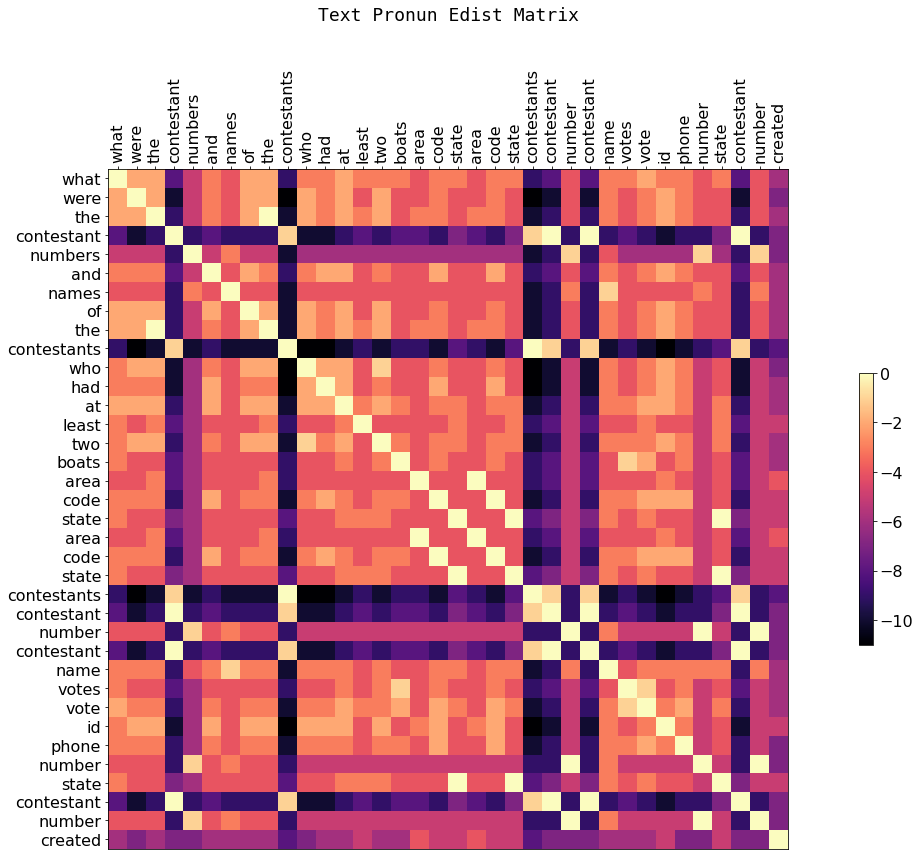

In [303]:
fig = MatrixVisualize(-_pronun_edist_matrix, non_empty_tokens, non_empty_tokens, 'Text Pronun Edist Matrix', cmap='magma')

In [304]:
_pronun_sim_matrix = np.zeros((len(non_empty_ids), len(non_empty_ids)))
for i in range(len(non_empty_ids)):
    pos_i = non_empty_ids[i]
    for j in range(len(non_empty_ids)):
        pos_j = non_empty_ids[j]
        _pronun_sim_matrix[i, j] = WordPronSimilarity(str(_tokens[pos_i]), str(_tokens[pos_j]))

_pronun_sim_matrix.shape

(36, 36)

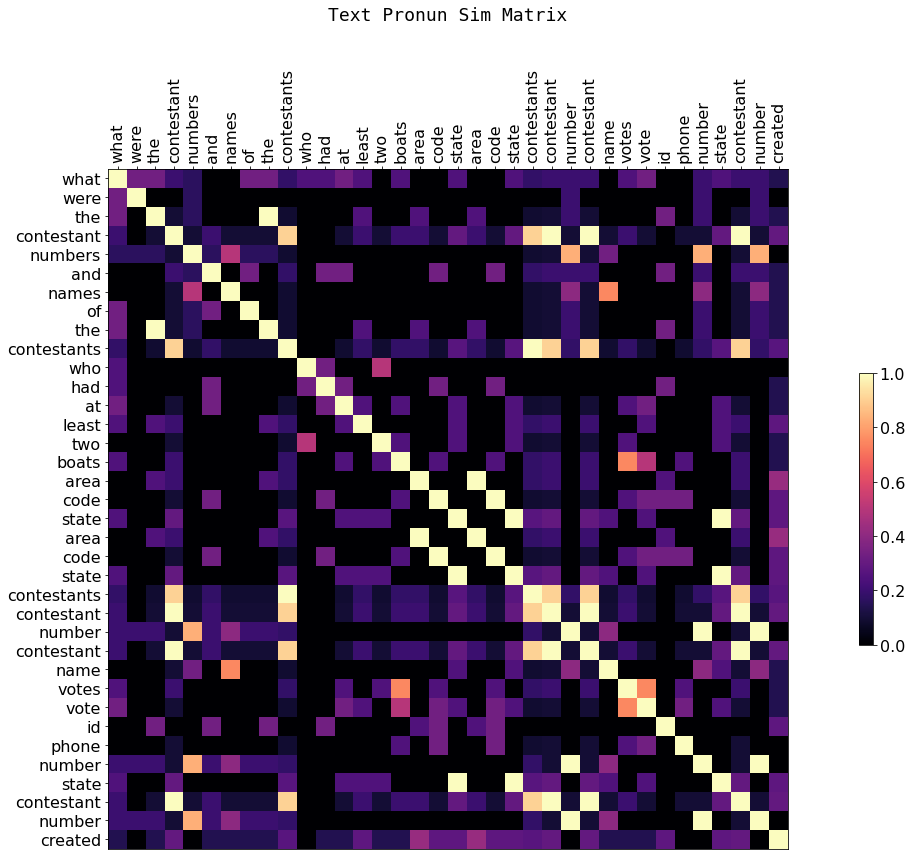

In [305]:
fig = MatrixVisualize(_pronun_sim_matrix, non_empty_tokens, non_empty_tokens, 'Text Pronun Sim Matrix', cmap='magma')

#### Raw feats

In [223]:
_raw_audio_feats = _tensor_dict['audio_feats']
_raw_audio_feats.size()

torch.Size([39, 25, 68])

In [224]:
_tokens[5], _raw_audio_feats[5]

(of,
 tensor([[ 4.1302e-02,  2.0311e-01,  3.1558e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 4.0050e-02,  8.4756e-02,  2.4461e+00,  ...,  2.9689e-03,
           2.3816e-03, -3.7342e-03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]))

In [225]:
_tokens[23], _raw_audio_feats[23]

(schooler,
 tensor([[ 2.3780e-02,  2.3776e-08,  3.1483e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.7910e-01,  1.3014e-04,  1.2910e+00,  ..., -1.2914e-01,
           5.0980e-04, -3.4407e-02],
         [ 6.2328e-01,  2.3558e-03,  2.5347e+00,  ..., -6.8059e-04,
           2.8158e-03, -5.2579e-04],
         ...,
         [ 3.5044e-02,  2.1803e-02,  3.1864e+00,  ..., -2.8729e-03,
          -7.9077e-04,  9.7088e-03],
         [ 2.7534e-02,  1.2797e-02,  3.0689e+00,  ...,  3.6957e-03,
          -5.5029e-04, -7.6779e-03],
         [ 5.3817e-02,  3.9234e-03,  2.2413e+00,  ...,  5.7057e-03,
           8.3430e-05, -9.1863e-03]]))

In [226]:
_raw_audio_resized = _raw_audio_feats.reshape(len(_tokens), -1)
_raw_audio_resized.size()

torch.Size([39, 1700])

In [227]:
non_empty_audio = [_raw_audio_resized[i].numpy() for i in non_empty_ids]
print(non_empty_tokens, len(non_empty_tokens))

[show, the, names, of, all, of, the, high, school, our, Kyle's, friends, friend, student, id, friend, id, high, schooler, id, name, grade, likes, student, id, liked, id] 27


In [ ]:
_dot_matrix = np.zeros((len(non_empty_ids), len(non_empty_ids)))
for i in range(len(non_empty_ids)):
    pos_i = non_empty_ids[i]
    for j in range(len(non_empty_ids)):
        pos_j = non_empty_ids[j]
        _dot_matrix[i, j] = torch.dot(_raw_audio_resized[pos_i], _raw_audio_resized[pos_j])

_dot_matrix.shape

In [ ]:
fig = MatrixVisualize(_dot_matrix, non_empty_tokens, non_empty_tokens, 'Raw Audio Feats Dot Matrix', cmap='magma')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

_cos_matrix = cosine_similarity(non_empty_audio, non_empty_audio)

_cos_matrix.shape

In [ ]:
fig = MatrixVisualize(_cos_matrix, non_empty_tokens, non_empty_tokens, 'Raw Audio Feats Cosine Matrix', cmap='magma')

In [ ]:
_l2_matrix = np.zeros((len(non_empty_ids), len(non_empty_ids)))
for i in range(len(non_empty_ids)):
    pos_i = non_empty_ids[i]
    for j in range(len(non_empty_ids)):
        pos_j = non_empty_ids[j]
        _l2_matrix[i, j] = np.linalg.norm(_raw_audio_resized[pos_i] - _raw_audio_resized[pos_j])

_l2_matrix.shape

In [ ]:
fig = MatrixVisualize(-_l2_matrix, non_empty_tokens, non_empty_tokens, 'Raw Audio Feats L2 Matrix', cmap='magma')

#### Encoded audio feats

In [353]:
_enc_audio_feats = ILM_model.audio_seq2vec_encoder(_tensor_dict['audio_feats'], _tensor_dict['audio_mask']).detach()
_enc_audio_feats.size()

torch.Size([42, 128])

In [354]:
_tensor_dict['audio_feats'].size(), _tensor_dict['audio_mask'].size()

(torch.Size([42, 25, 68]), torch.Size([42, 25]))

In [ ]:
_tensor_dict['audio_feats']

In [ ]:
_tensor_dict['audio_mask']

In [355]:
# test[22]
_enc_audio_feats

tensor([[-0.1760,  0.0293, -0.0856,  ..., -0.0488,  0.1008, -0.0941],
        [ 0.0851,  0.0721, -0.0454,  ..., -0.0253,  0.0932, -0.0400],
        [ 0.2042,  0.0159, -0.0410,  ..., -0.0344,  0.1732, -0.0056],
        ...,
        [ 0.2809, -0.0189,  0.0319,  ...,  0.0318, -0.3104,  0.0550],
        [ 1.6807, -0.1759, -0.0575,  ..., -0.0144,  0.1177,  0.1431],
        [-0.1816,  0.0094, -0.0205,  ...,  0.0059,  0.0699, -0.0197]])

In [ ]:
# test[?]
_enc_audio_feats

In [356]:
non_empty_enc_audio = [_enc_audio_feats[i].numpy() for i in non_empty_ids]

In [ ]:
_dot_matrix = np.zeros((len(non_empty_ids), len(non_empty_ids)))
for i in range(len(non_empty_ids)):
    for j in range(len(non_empty_ids)):
        _dot_matrix[i, j] = np.dot(non_empty_enc_audio[i], non_empty_enc_audio[j])

_dot_matrix.shape

In [ ]:
fig = MatrixVisualize(_dot_matrix, non_empty_tokens, non_empty_tokens, 'Encoded Audio Feats Dot Matrix', cmap='magma')


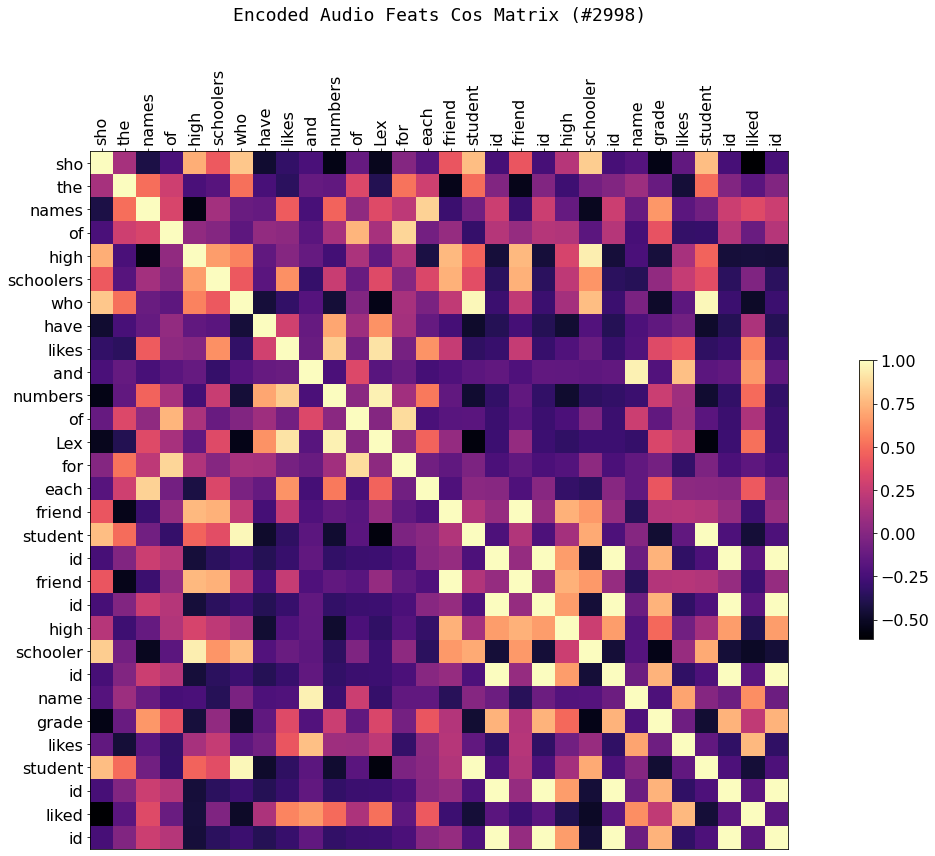

In [361]:
_cos_matrix = cosine_similarity(non_empty_enc_audio, non_empty_enc_audio)

fig = MatrixVisualize(_cos_matrix, 
                      non_empty_tokens, 
                      non_empty_tokens, 
                      f'Encoded Audio Feats Cos Matrix (#{_inspect_id})',
                      cmap='magma')


In [ ]:
_l2_matrix = np.zeros((len(non_empty_ids), len(non_empty_ids)))
for i in range(len(non_empty_ids)):
    for j in range(len(non_empty_ids)):
        _l2_matrix[i, j] = np.linalg.norm(non_empty_enc_audio[i] - non_empty_enc_audio[j])

_l2_matrix.shape

In [ ]:
fig = MatrixVisualize(-_l2_matrix, non_empty_tokens, non_empty_tokens, 'Encoded Audio Feats L2 Matrix', cmap='magma')


#### Attention map

In [362]:
predictor_output = predictor.predict_instance(_test_instance)
predictor_output.keys()

dict_keys(['question', 'original_id', 'rewriter_tags', 'align_tags', 'rewrite_seq_prediction', 'rewrite_seq_prediction_cands', 'rewrite_seq_NLL', 'rewrite_seq_prediction_intermediates'])

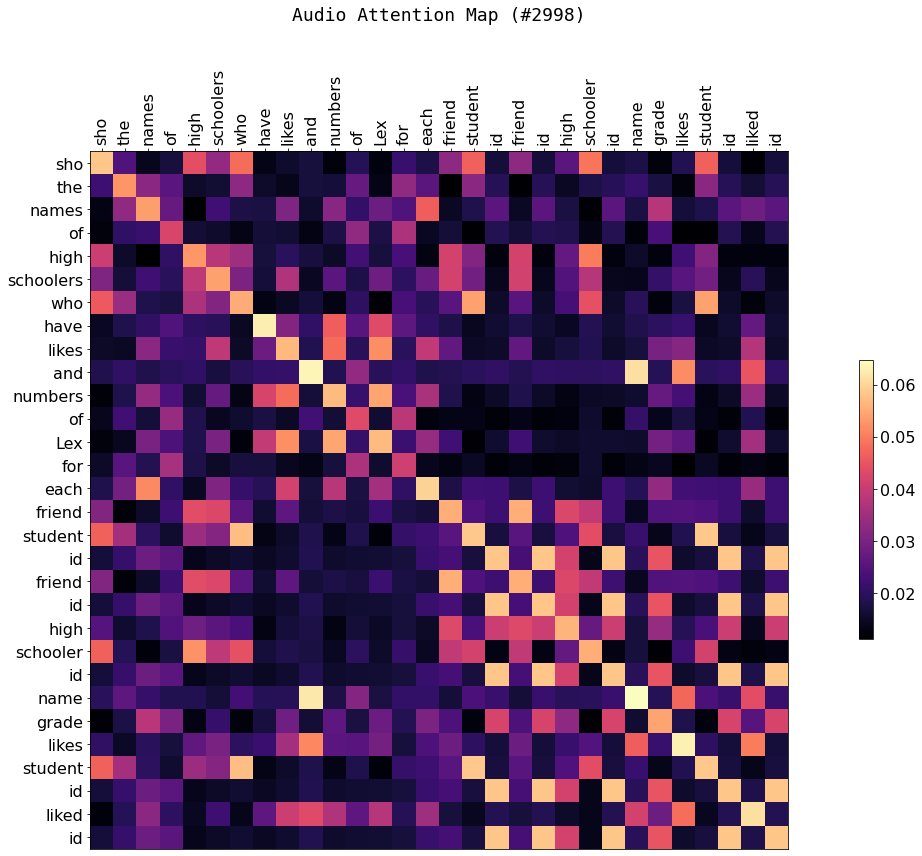

In [363]:
# att map

_att_map = np.array(predictor_output['rewrite_seq_prediction_intermediates']['encoder']['audio_attention_map_0'][0])

_non_empty_att_map = _att_map[tuple(np.meshgrid(non_empty_ids, non_empty_ids)[::-1])]

fig = MatrixVisualize(_non_empty_att_map,
                      non_empty_tokens,
                      non_empty_tokens,
                      f'Audio Attention Map (#{_inspect_id})',
                      cmap='magma')


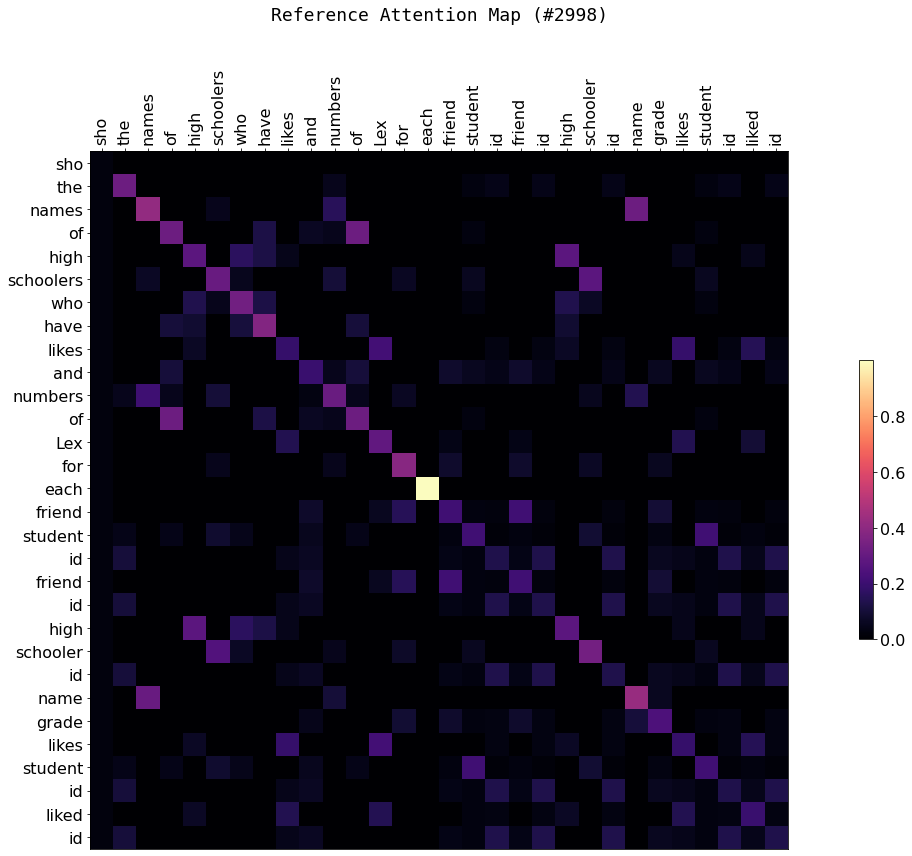

In [364]:
_ref_att_map = _tensor_dict['ref_att_map'].detach().numpy()

_non_empty_ref_att_map = _ref_att_map[tuple(np.meshgrid(non_empty_ids, non_empty_ids)[::-1])]

fig = MatrixVisualize(_non_empty_ref_att_map,
                      non_empty_tokens,
                      non_empty_tokens,
                      f'Reference Attention Map (#{_inspect_id})',
                      cmap='magma')



#### Actual predictions

In [316]:
predictor_output['rewrite_seq_prediction_cands']

[['are', '[ANS]', 'votes', '[ANS]', '@end@', '@end@'],
 ['What', 'are', '[ANS]', 'votes', '[ANS]', '@end@'],
 ['are', '[ANS]', 'songs', '[ANS]', '@end@', '@end@'],
 ['are', '[ANS]', 'ages', '[ANS]', '@end@', '@end@']]

In [ ]:
## all encoded audio feats identical?? (true for 2.12.3.0i|2i)

for ex_id in range(20):
    _test_instance = Instance(test_dataset[ex_id].fields)
    _test_instance.index_fields(ILM_model.vocab)
    _tensor_dict = _test_instance.as_tensor_dict()

    _enc_audio_feats = ILM_model.audio_seq2vec_encoder(_tensor_dict['audio_feats'], _tensor_dict['audio_mask']).detach()

    print(_enc_audio_feats)
    print()

In [ ]:
## If we use random values, won't be identical 

for ex_id in range(20):
    _test_instance = Instance(test_dataset[ex_id].fields)
    _test_instance.index_fields(ILM_model.vocab)
    _tensor_dict = _test_instance.as_tensor_dict()

    _enc_audio_feats = ILM_model.audio_seq2vec_encoder(
        torch.randn_like(_tensor_dict['audio_feats']),
        _tensor_dict['audio_mask']).detach()

    print(_enc_audio_feats)
    print()

In [189]:
ILM_model.audio_seq2vec_encoder

CnnEncoder(
  (_activation): ReLU()
  (conv_layer_0): Conv1d(68, 4, kernel_size=(2,), stride=(1,))
  (conv_layer_1): Conv1d(68, 4, kernel_size=(3,), stride=(1,))
  (conv_layer_2): Conv1d(68, 4, kernel_size=(4,), stride=(1,))
  (conv_layer_3): Conv1d(68, 4, kernel_size=(5,), stride=(1,))
  (projection_layer): Linear(in_features=16, out_features=128, bias=True)
)

In [ ]:
ILM_model.audio_seq2vec_encoder.conv_layer_0.weight

In [ ]:
ILM_model.audio_seq2vec_encoder.conv_layer_0.bias

In [ ]:
ex_id = 0

_test_instance = Instance(test_dataset[ex_id].fields)
_test_instance.index_fields(ILM_model.vocab)
_tensor_dict = _test_instance.as_tensor_dict()

_tensor_dict['audio_feats'], _tensor_dict['audio_mask']

In [ ]:
## Dive into cnn

from allennlp.nn.util import min_value_of_dtype

tokens = _tensor_dict['audio_feats']
mask = _tensor_dict['audio_mask']

if mask is not None:
    tokens = tokens * mask.unsqueeze(-1)

# Our input is expected to have shape `(batch_size, num_tokens, embedding_dim)`.  The
# convolution layers expect input of shape `(batch_size, in_channels, sequence_length)`,
# where the conv layer `in_channels` is our `embedding_dim`.  We thus need to transpose the
# tensor first.
tokens = torch.transpose(tokens, 1, 2)
# Each convolution layer returns output of size `(batch_size, num_filters, pool_length)`,
# where `pool_length = num_tokens - ngram_size + 1`.  We then do an activation function,
# masking, then do max pooling over each filter for the whole input sequence.
# Because our max pooling is simple, we just use `torch.max`.  The resultant tensor has shape
# `(batch_size, num_conv_layers * num_filters)`, which then gets projected using the
# projection layer, if requested.

# To ensure the cnn_encoder respects masking we add a large negative value to
# the activations of all filters that convolved over a masked token. We do this by
# first enumerating all filters for a given convolution size (torch.arange())
# then by comparing it to an index of the last filter that does not involve a masked
# token (.ge()) and finally adjusting dimensions to allow for addition and multiplying
# by a large negative value (.unsqueeze())
filter_outputs = []
batch_size = tokens.shape[0]
# shape: (batch_size, 1)
last_unmasked_tokens = mask.sum(dim=1).unsqueeze(dim=-1)
for i in range(len(ILM_model.audio_seq2vec_encoder._convolution_layers)):
    convolution_layer = getattr(ILM_model.audio_seq2vec_encoder, "conv_layer_{}".format(i))
    pool_length = tokens.shape[2] - convolution_layer.kernel_size[0] + 1

    # Forward pass of the convolutions.
    # shape: (batch_size, num_filters, pool_length)
    _conv_out = convolution_layer(tokens)
    
    print(f'#{i}-0', _conv_out, _conv_out.size())
    
    activations = ILM_model.audio_seq2vec_encoder._activation(_conv_out)
    
    print(f'#{i}-1', activations, activations.size())

    # Create activation mask.
    # shape: (batch_size, pool_length)
    indices = (
        torch.arange(pool_length, device=activations.device)
        .unsqueeze(0)
        .expand(batch_size, pool_length)
    )
    # shape: (batch_size, pool_length)
    activations_mask = indices.ge(
        last_unmasked_tokens - convolution_layer.kernel_size[0] + 1
    )
    # shape: (batch_size, num_filters, pool_length)
    activations_mask = activations_mask.unsqueeze(1).expand_as(activations)
    
    print(f'#{i}-2', activations_mask, activations_mask.size())

    # Replace masked out values with smallest possible value of the dtype so
    # that max pooling will ignore these activations.
    # shape: (batch_size, pool_length)
    activations = activations + (activations_mask * min_value_of_dtype(activations.dtype))
    
    print(f'#{i}-3', activations, activations.size())
    
    _filter_out = activations.max(dim=2)[0]
    print(f'#{i}-4', _filter_out, _filter_out.size())

    # Pick out the max filters
    filter_outputs.append(_filter_out)

# Now we have a list of `num_conv_layers` tensors of shape `(batch_size, num_filters)`.
# Concatenating them gives us a tensor of shape `(batch_size, num_filters * num_conv_layers)`.
maxpool_output = (
    torch.cat(filter_outputs, dim=1) if len(filter_outputs) > 1 else filter_outputs[0]
)

# Replace the maxpool activations that picked up the masks with 0s
maxpool_output[maxpool_output == min_value_of_dtype(maxpool_output.dtype)] = 0.0

if ILM_model.audio_seq2vec_encoder.projection_layer:
    result = ILM_model.audio_seq2vec_encoder.projection_layer(maxpool_output)
else:
    result = maxpool_output

In [ ]:
filter_outputs

In [ ]:
maxpool_output

In [ ]:
'''
Result (audio_seq2vec_encoder):
At the first layer, after conv, values go to all negative, and after activation, they go to all 0.
This is learned - init models don't have this issue. Also, random (randn) feats don't have this issue.
TODO:
0. ReLU -> LeakyReLU
1. add a reconstruction task on encoded audio feats (predict raw audio feats / token)
'''

#### Check a model

In [176]:
alt_model = Model.from_archive('runs/2.16.2.1i/model.tar.gz')
_audio_encoded = alt_model.audio_seq2vec_encoder(_tensor_dict['audio_feats'], _tensor_dict['audio_mask'])
_audio_encoded.sum(dim=-1)

self._start_index: 3, @start@
self._end_index: 4, @end@
self._pad_index: 0, @@PADDING@@


tensor([-0.1850,  0.2997, -1.3077, -0.6420, -4.2652,  1.0450, -1.2064,  4.0502,
         0.1342, -5.8691,  3.8741,  2.0295,  0.2997, -2.6877,  0.2997, -2.3535,
         4.9455,  0.2997, -2.3535, -4.7277,  0.2997, -9.4096,  0.2997, -6.6823,
         0.2997, -3.0341,  0.2997,  1.2824,  0.2997, -3.3668,  4.1755,  0.2997,
        -3.3668, -4.7277,  0.2997, -6.6823,  0.2997, -6.6823, -5.9387,  0.2997,
         1.2022,  0.2997, -2.3535,  0.2997,  1.4218, -3.8857,  0.2997,  3.2576,
        -3.3668,  0.2997, -8.6342, -3.3668,  0.2997], grad_fn=<SumBackward1>)

In [177]:
for _t, _enc in zip(_tokens, _audio_encoded.sum(dim=-1).detach().numpy().tolist()):
    print(f'{str(_t):12}{_enc:.2}')

What        -0.18
?           0.3
Our         -1.3
flight      -0.64
numbers     -4.3
of          1.0
flights     -1.2
arriving    4.1
at          0.13
airports    -5.9
a           3.9
PG          2.0
[SEP]       0.3
airlines    -2.7
:           0.3
airline     -2.4
id          4.9
,           0.3
airline     -2.4
name        -4.7
,           0.3
abbreviation-9.4
,           0.3
country     -6.7
.           0.3
airports    -3.0
:           0.3
city        1.3
,           0.3
airport     -3.4
code        4.2
,           0.3
airport     -3.4
name        -4.7
,           0.3
country     -6.7
,           0.3
country     -6.7
abbrev      -5.9
.           0.3
flights     1.2
:           0.3
airline     -2.4
,           0.3
flight      1.4
number      -3.9
,           0.3
source      3.3
airport     -3.4
,           0.3
destination -8.6
airport     -3.4
.           0.3


### Gated Fusion - gates

In [7]:
_test_instance = Instance(test_dataset[44].fields)
_test_instance.fields

{'sentence': <allennlp.data.fields.text_field.TextField at 0x1434aac30>,
 'text_mask': <allennlp.data.fields.array_field.ArrayField at 0x1434aae60>,
 'schema_mask': <allennlp.data.fields.array_field.ArrayField at 0x1434aab40>,
 'schema_column_ids': <allennlp.data.fields.array_field.ArrayField at 0x1434aa690>,
 'audio_feats': <allennlp.data.fields.list_field.ListField at 0x14356a5d0>,
 'audio_mask': <allennlp.data.fields.array_field.ArrayField at 0x1434aa640>,
 'rewriter_tags': <allennlp.data.fields.sequence_label_field.SequenceLabelField at 0x144227d10>,
 'align_tags': <allennlp.data.fields.sequence_label_field.SequenceLabelField at 0x144227e30>,
 'rewrite_seq': <allennlp.data.fields.text_field.TextField at 0x1434b4780>,
 'metadata': <allennlp.data.fields.metadata_field.MetadataField at 0x14356a690>}

In [12]:
print(_test_instance.fields['sentence'].tokens)
print(_test_instance.fields['rewrite_seq'].tokens)

[What, is, the, number, of, votes, from, state, and, Y, or, see, a, ., [SEP], area, code, state, :, area, code, ,, state, ., contestants, :, contestant, number, ,, contestant, name, ., votes, :, vote, id, ,, phone, number, ,, state, ,, contestant, number, ,, created, .]
[@start@, What, are, [ANS], 'NY, ', [ANS], 'CA, ', [ANS], ?, [ANS], @end@]


In [37]:
_tensor_dict = _test_instance.as_tensor_dict()
_tensor_dict.keys()

dict_keys(['sentence', 'text_mask', 'schema_mask', 'schema_column_ids', 'audio_feats', 'audio_mask', 'rewriter_tags', 'align_tags', 'rewrite_seq', 'metadata'])

In [4]:
gf_ILM_model = Model.from_archive('runs/2.14.0.0i/model.tar.gz')

self._start_index: 3, @start@
self._end_index: 4, @end@
self._pad_index: 0, @@PADDING@@


In [6]:
gf_predictor = SpiderASRRewriterPredictor_ILM(model=gf_ILM_model,
                                              dataset_reader=dataset_reader)
gf_predictor.set_save_intermediate(True)

In [13]:
gf_pred_out = gf_predictor.predict_instance(_test_instance)
gf_pred_out.keys()

dict_keys(['question', 'original_id', 'rewriter_tags', 'align_tags', 'rewrite_seq_prediction', 'rewrite_seq_prediction_cands', 'rewrite_seq_NLL', 'rewrite_seq_prediction_intermediates'])

In [21]:
_token_gate = gf_pred_out['rewrite_seq_prediction_intermediates']['encoder']['token_gate']
_audio_gate = gf_pred_out['rewrite_seq_prediction_intermediates']['encoder']['audio_gate']
_tag_gate = gf_pred_out['rewrite_seq_prediction_intermediates']['encoder']['tag_gate']

np.mean(_token_gate), np.mean(_audio_gate), np.mean(_tag_gate)

(0.45281933273358416, 0.45054028039670385, 0.4859624328109237)

In [22]:
np.array(_token_gate).shape

(1, 47, 256)

In [32]:
_test_instance.fields['sentence'].tokens[7], np.mean(_token_gate[0][7]), np.mean(_audio_gate[0][7]), np.mean(_tag_gate[0][7])

(state, 0.49049099343437946, 0.4706899166044084, 0.47619011712929354)

In [33]:
_test_instance.fields['sentence'].tokens[11], np.mean(_token_gate[0][11]), np.mean(_audio_gate[0][11]), np.mean(_tag_gate[0][11])

(see, 0.541033159667043, 0.4341624717849897, 0.4389960773969267)

In [34]:
_test_instance.fields['sentence'].tokens[15], np.mean(_token_gate[0][15]), np.mean(_audio_gate[0][15]), np.mean(_tag_gate[0][15])

(area, 0.42531585083140017, 0.4511516102253258, 0.5075576908005089)

In [35]:
_test_instance.fields['sentence'].tokens[18], np.mean(_token_gate[0][18]), np.mean(_audio_gate[0][18]), np.mean(_tag_gate[0][18])

(:, 0.4383045507386985, 0.449692172756906, 0.5016281215996194)

### Attention Visualizations

In [112]:
def Postprocess_rewrite_seq(tags, rewrite_seq, question_toks):
    _question_toks_placeholders = []

    for i, tok in enumerate(question_toks):
        if tags[i].endswith('KEEP'):
            _question_toks_placeholders.append(tok)
        elif (tags[i] == 'U-EDIT') or (tags[i] == 'B-EDIT'):
            _question_toks_placeholders.append('[EDIT]')
        elif (tags[i] == 'I-EDIT') or (tags[i] == 'L-EDIT') or tags[i].endswith('DEL'):
            pass
        else:
            print('Unknown tag: {}'.format(tags[i]))

    _edits = []
    _curr_edit = []
    for tok in rewrite_seq:
        if tok == '[ANS]':
            _edits.append(_curr_edit)
            _curr_edit = []
        elif tok == '[END_RWT]':
            break
        else:
            _curr_edit.append(tok)
    
    _question_toks_rewritten = []
    _edit_idx = 0
    for tok in _question_toks_placeholders:
        if tok == '[EDIT]':
            if _edit_idx >= len(_edits):
                print('--- Not enough edits ---')
                print('Tags:', tags)
                print('Edits:', _edits)
            else:
                _question_toks_rewritten.extend(_edits[_edit_idx])
            _edit_idx += 1
        else:
            _question_toks_rewritten.append(tok)

    return _question_toks_rewritten

In [128]:
def FormatInstanceTexts(instance, predictor_output):
    tokens = [t.text for t in test_dataset[idx].fields['sentence']]
    text_len = tokens.index('[SEP]')
    text_tokens = tokens[:text_len]
    orig_q_tokens = original_dev_dataset[predictor_output['original_id']]['question_toks']
    
    _tags = predictor_output['tags_prediction']
    _rewrite_seq = predictor_output['rewrite_seq_prediction'][:predictor_output['rewrite_seq_prediction'].index('[END_RWT]')]

    tags_str = ' '.join([tok if tag.endswith('KEEP') else '([{}] {})'.format(tag, tok) for tag, tok in zip(_tags, text_tokens)])

    rewritten_q = Postprocess_rewrite_seq(_tags, _rewrite_seq, text_tokens)

    fmt_lines = [
        'Gold Q: ' + ' '.join(orig_q_tokens),
        'Tagging: ' + tags_str,
        'Rewrite_seq: ' + ' '.join(_rewrite_seq),
        'Rewritten Q: ' + ' '.join(rewritten_q)
    ]
    fmt_align_len = max([len(l) for l in fmt_lines])

    fmt_str = '{0:{4}}\n{1:{4}}\n{2:{4}}\n{3:{4}}'.format(*fmt_lines, fmt_align_len)
    
    return fmt_str

In [98]:
_att_map = np.array(predictor_output['tag_prediction_intermediates']['encoder_no_tags']['audio_attention_map'][0])
_att_map.shape

(57, 57)

In [ ]:
tokens = [t.text for t in _test_instance.fields['sentence']]
orig_q_tokens = original_dev_dataset[predictor_output['original_id']]['question_toks']
len(tokens), len(orig_q_tokens)

In [ ]:
text_len = tokens.index('[SEP]')
text_tokens = tokens[:text_len]
text_tokens

In [ ]:
_tags, _rewrite_seq = predictor_output['tags_prediction'], predictor_output['rewrite_seq_prediction'][:predictor_output['rewrite_seq_prediction'].index('[END_RWT]')]
_tags, _rewrite_seq

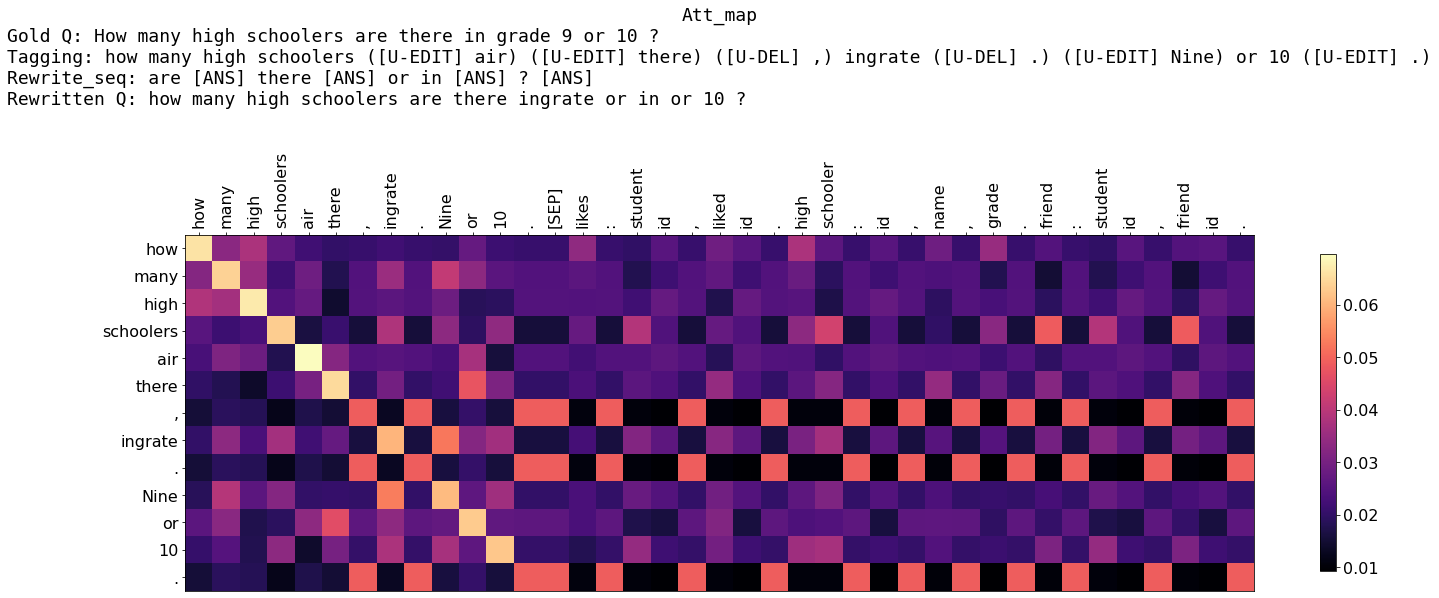

In [129]:
# tags_str = ' '.join([tok if tag.endswith('KEEP') else '([{}] {})'.format(tag, tok) for tag, tok in zip(_tags, text_tokens)])

# rewritten_q = Postprocess_rewrite_seq(_tags, _rewrite_seq, text_tokens)

# title_lines = [
#     'Gold Q: ' + ' '.join(orig_q_tokens),
#     'Tagging: ' + tags_str,
#     'Rewrite_seq: ' + ' '.join(_rewrite_seq),
#     'Rewritten Q: ' + ' '.join(rewritten_q)
# ]
# title_align_len = max([len(l) for l in title_lines])

# title_str = 'Att_map\n{0:{4}}\n{1:{4}}\n{2:{4}}\n{3:{4}}'.format(
#     *title_lines,
#     title_align_len
# )

title_str = 'Att_map\n{}'.format(FormatInstanceTexts(_test_instance, predictor_output))

fig = MatrixVisualize(_att_map[:text_len, :], text_tokens, tokens, title_str)

In [ ]:
_bert_embs = np.array(predictor_output['tag_prediction_intermediates']['rewriter_main']['bert_embedding'][0])
_bert_embs.shape

In [ ]:
_cos_matrix = pairwise.cosine_similarity(_bert_embs)
fig = MatrixVisualize(_cos_matrix, tokens, tokens, 'BERT emb cos sim', cmap='Reds')

In [62]:
plt.close('all')

In [130]:
# inspect_ids = [8, 96, 272, 448, 1416, 1592, 1680, 1856, 2120, 2296, 2384, 2560, 2824]
inspect_ids = [8, 96, 272, 448, 1416, 1856, 2120, 2296, 2384, 2560, 2824]

In [131]:
img_dir = '/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/Modeling/images/inspection'
os.makedirs(img_dir, exist_ok=True)

for idx in tqdm(inspect_ids):
    predictor_output = predictor.predict_instance(test_dataset[idx])
    tokens = [t.text for t in test_dataset[idx].fields['sentence']]
    text_len = tokens.index('[SEP]')
    text_tokens = tokens[:text_len]
    # orig_q_tokens = original_dev_dataset[predictor_output['original_id']]['question_toks']
    
    fmt_instance_str = FormatInstanceTexts(test_dataset[idx], predictor_output)
    
    fig_name = 'test{}.main.bert_embedding_cos_matrix'.format(idx)
    _bert_embs = np.array(predictor_output['tag_prediction_intermediates']['rewriter_main']['bert_embedding'][0])
    _bert_embs_2 = np.array(predictor_output['rewrite_seq_prediction_intermediates']['rewriter_main']['bert_embedding'][0])
    assert np.allclose(_bert_embs, _bert_embs_2), idx
    _cos_matrix = pairwise.cosine_similarity(_bert_embs[:text_len], _bert_embs)
    fig = MatrixVisualize(_cos_matrix, text_tokens, tokens, title='{}\n{}'.format(fig_name, fmt_instance_str), cmap='Reds')
    fig.savefig(os.path.join(img_dir, '{}.png'.format(fig_name)))
    
    fig_name = 'test{}.no_tags.att_map'.format(idx)
    _att_map = np.array(predictor_output['tag_prediction_intermediates']['encoder_no_tags']['audio_attention_map'][0])
    _att_map_2 = np.array(predictor_output['rewrite_seq_prediction_intermediates']['encoder_no_tags']['audio_attention_map'][0])
    assert np.allclose(_att_map, _att_map_2), idx
    fig = MatrixVisualize(_att_map[:text_len, :], text_tokens, tokens, title='{}\n{}'.format(fig_name, fmt_instance_str), cmap='magma')
    fig.savefig(os.path.join(img_dir, '{}.png'.format(fig_name)))
    
    fig_name = 'test{}.no_tags.att_out_with_res_cos_matrix'.format(idx)
    _att_out = np.array(predictor_output['tag_prediction_intermediates']['encoder_no_tags']['audio_attention_out_with_residual'][0])
    _att_out_2 = np.array(predictor_output['rewrite_seq_prediction_intermediates']['encoder_no_tags']['audio_attention_out_with_residual'][0])
    assert np.allclose(_att_out, _att_out_2), idx
    _cos_matrix = pairwise.cosine_similarity(_att_out[:text_len], _att_out)
    fig = MatrixVisualize(_cos_matrix, text_tokens, tokens, title='{}\n{}'.format(fig_name, fmt_instance_str), cmap='Reds')
    fig.savefig(os.path.join(img_dir, '{}.png'.format(fig_name)))
    
    fig_name = 'test{}.no_tags.encoder_repr_cos_matrix'.format(idx)
    _enc = np.array(predictor_output['tag_prediction_intermediates']['encoder_no_tags']['encoder_representation_0'][0])
    _enc_2 = np.array(predictor_output['rewrite_seq_prediction_intermediates']['encoder_no_tags']['encoder_representation_0'][0])
    assert np.allclose(_enc, _enc_2), idx
    _cos_matrix = pairwise.cosine_similarity(_enc[:text_len], _enc)
    fig = MatrixVisualize(_cos_matrix, text_tokens, tokens, title='{}\n{}'.format(fig_name, fmt_instance_str), cmap='Reds')
    fig.savefig(os.path.join(img_dir, '{}.png'.format(fig_name)))
    
    fig_name = 'test{}.with_tags.att_map'.format(idx)
    _att_map = np.array(predictor_output['rewrite_seq_prediction_intermediates']['encoder_with_tags']['audio_attention_map'][0])
    fig = MatrixVisualize(_att_map[:text_len, :], text_tokens, tokens, title='{}\n{}'.format(fig_name, fmt_instance_str), cmap='magma')
    fig.savefig(os.path.join(img_dir, '{}.png'.format(fig_name)))
    
    fig_name = 'test{}.with_tags.att_out_with_res_cos_matrix'.format(idx)
    _att_out = np.array(predictor_output['tag_prediction_intermediates']['encoder_with_tags']['audio_attention_out_with_residual'][0])
    _cos_matrix = pairwise.cosine_similarity(_att_out[:text_len], _att_out)
    fig = MatrixVisualize(_cos_matrix, text_tokens, tokens, title='{}\n{}'.format(fig_name, fmt_instance_str), cmap='Reds')
    fig.savefig(os.path.join(img_dir, '{}.png'.format(fig_name)))
    
    fig_name = 'test{}.with_tags.encoder_repr_cos_matrix'.format(idx)
    _enc = np.array(predictor_output['tag_prediction_intermediates']['encoder_with_tags']['encoder_representation_0'][0])
    _cos_matrix = pairwise.cosine_similarity(_enc[:text_len], _enc)
    fig = MatrixVisualize(_cos_matrix, text_tokens, tokens, title='{}\n{}'.format(fig_name, fmt_instance_str), cmap='Reds')
    fig.savefig(os.path.join(img_dir, '{}.png'.format(fig_name)))
    
    plt.close('all')
    

### Check vocabs

In [155]:
ILM_model.vocab

Vocabulary with namespaces:  phonemes, Size: 59 || tgt_tokens, Size: 10 || align_tags, Size: 12 || rewriter_tags, Size: 8 || token_characters, Size: 46 || Non Padded Namespaces: {'*tags', '*labels'}

In [157]:
list(ILM_model.vocab.get_index_to_token_vocabulary('tgt_tokens').items())

[(0, '@@PADDING@@'),
 (1, '@@UNKNOWN@@'),
 (2, '[ANS]'),
 (3, '@start@'),
 (4, '@end@'),
 (5, '?'),
 (6, 'speed'),
 (7, 'in'),
 (8, 'grouped'),
 (9, '@COPY@')]

In [78]:
_t2i_dict = ILM_model.rewrite_decoder._vocab.get_token_to_index_vocabulary(namespace="tgt_tokens")
_i2t_dict = ILM_model.rewrite_decoder._vocab.get_index_to_token_vocabulary(namespace="tgt_tokens")
len(_t2i_dict), len(_i2t_dict)

(2688, 2688)

In [79]:
_t2i_dict['@@UNKNOWN@@'], _t2i_dict['@COPY@']

(1, 2687)

### Input sequence check

In [23]:
## input are not lowered, but bert-tokenizer takes care of it 

In [13]:
list(_test_instance.fields['metadata'].keys())

['original_id',
 'text_len',
 'schema_len',
 'concat_len',
 'text_tokens',
 'schema_tokens',
 'concat_tokens',
 'source_tokens',
 'target_tokens',
 'rewrite_seq_len']

In [15]:
for i, _test_instance in enumerate(test_dataset):
#     o_id = _test_instance.fields['metadata']['original_id']
#     o_cand = original_dev_dataset[o_id]
#     print(list(zip(o_cand['question'])))
    print(' '.join(_test_instance.fields['metadata']['concat_tokens']))
    print(' '.join(t.text for t in _test_instance.fields['metadata']['target_tokens']))
    print()

give the name of the student with the most likes . [SEP] friend : student id ; friend id . high schooler : id ; name ; grade . likes : student id ; liked id .


what is the name of country that has the shortest life expectancy in Asia ? [SEP] city : id ; name ; country code ; district ; population . country : code ; name ; continent ; region ; surface area ; indepdent year ; population ; life expectancy ; gnp ; gnp old ; local name ; government form ; head of state ; capital ; code2 . countrylanguage : countrycode ; language ; is official ; percentage . sqlite sequence : name ; seq .


which country does airline JetBlue Airways belong to ? [SEP] airlines : airline id ; airline name ( AirTran Airways , Allegiant Air , Continental Airlines ) ; abbreviation ; country . airports : city ; airport code ( ALN ) ; airport name ( Colorado Plains Regional Airport , Esler Field ) ; country ; country abbrev . flights : airline ; flight number ; source airport ; destination airport .
airline `` [AN

In [24]:
_asr_sen = 'What is the document ? I d 10 put idea and description for document named Robin CV .'

In [25]:
for i, _test_instance in enumerate(test_dataset):
    _text_tokens = _test_instance.fields['metadata']['text_tokens']
    _text = ' '.join([str(t) for t in _text_tokens])
    if _asr_sen.lower() == _text.lower():
        print(i)

128


In [26]:
_test_instance = test_dataset[128]

In [27]:
_test_instance.fields['metadata']['text_tokens']

['what',
 'is',
 'the',
 'document',
 '?',
 'i',
 'd',
 '10',
 'put',
 'idea',
 'and',
 'description',
 'for',
 'document',
 'named',
 'robin',
 'cv',
 '.']

In [28]:
' '.join(t.text for t in _test_instance.fields['sentence'].tokens)

'what is the document ? i d 10 put idea and description for document named robin cv . [SEP] documents : document id ; template id ; document name : robbin cv ; document description ; other details . paragraphs : paragraph id ; document id ; paragraph text ; other details . reference template types : template type code : cv ; template type description . templates : template id ; version number ; template type code ; date effective from ; date effective to ; template details .'

### Copy-mech check

In [33]:
test_dataset_path = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my/dev/test_rewriter+phonemes.json'
with open(test_dataset_path, 'r') as f:
    test_dataset_json = json.load(f)
test_dataset_json_flattened = [s[0] for s in test_dataset_json]
len(test_dataset_json_flattened)

547

In [21]:
_tgt_vocab = ILM_model.vocab.get_index_to_token_vocabulary(namespace='tgt_tokens')
len(_tgt_vocab)

2688

In [29]:
_test_instance = test_dataset[128]

In [30]:
list(_test_instance.keys())

['sentence',
 'text_mask',
 'schema_mask',
 'schema_column_ids',
 'audio_feats',
 'audio_mask',
 'phoneme_multilabels',
 'phoneme_labels',
 'phoneme_label_mask',
 'align_tags',
 'ref_att_map',
 'source_to_target',
 'rewriter_tags',
 'rewrite_seq',
 'source_token_ids',
 'target_token_ids',
 'metadata']

#### Check the raw/gold sentence, target seq, etc.

In [34]:
# o_id = _test_instance['metadata']['original_id']
# original_dev_dataset[o_id]['question']
test_dataset_json_flattened[128]['gold_question']

'What is the document id, template id and description for document named "Robbin CV"?'

In [35]:
test_dataset_json_flattened[128]['rewriter_edits']

[{'src_span': [5], 'tgt_span': [4], 'src_text': 'I', 'tgt_text': 'id'},
 {'src_span': [7, 8],
  'tgt_span': [6],
  'src_text': '10 put',
  'tgt_text': 'template'},
 {'src_span': [9], 'tgt_span': [7], 'src_text': 'idea', 'tgt_text': 'id'},
 {'src_span': [14],
  'tgt_span': [12, 13],
  'src_text': 'named',
  'tgt_text': 'named ``'},
 {'src_span': [15],
  'tgt_span': [14],
  'src_text': 'Robin',
  'tgt_text': 'Robbin'},
 {'src_span': [16],
  'tgt_span': [15, 16],
  'src_text': 'CV',
  'tgt_text': "CV ''"},
 {'src_span': [17], 'tgt_span': [17], 'src_text': '.', 'tgt_text': '?'}]

In [36]:
' '.join(_test_instance.fields['metadata']['text_tokens'])

'what is the document ? i d 10 put idea and description for document named robin cv .'

In [37]:
concat_input_tokens = [t.text for t in _test_instance.fields['sentence'].tokens]
' '.join(concat_input_tokens)

'what is the document ? i d 10 put idea and description for document named robin cv . [SEP] documents : document id ; template id ; document name : robbin cv ; document description ; other details . paragraphs : paragraph id ; document id ; paragraph text ; other details . reference template types : template type code : cv ; template type description . templates : template id ; version number ; template type code ; date effective from ; date effective to ; template details .'

#### Predictor output

In [38]:
predictor_output = predictor.predict_instance(_test_instance)

In [39]:
predictor_output.keys()

dict_keys(['question', 'original_id', 'rewriter_tags', 'align_tags', 'rewrite_seq_prediction', 'rewrite_seq_prediction_cands', 'rewrite_seq_NLL', 'rewrite_seq_prediction_intermediates'])

In [41]:
decoder_intermediates = predictor_output['rewrite_seq_prediction_intermediates']['decoder']
decoder_intermediates.keys()

dict_keys(['input_choices:step_0', 'generation_scores:step_0', 'copy_scores:step_0', 'step_target_tokens:step_0', 'input_choices:step_1', 'generation_scores:step_1', 'copy_scores:step_1', 'step_target_tokens:step_1', 'input_choices:step_2', 'generation_scores:step_2', 'copy_scores:step_2', 'step_target_tokens:step_2', 'input_choices:step_3', 'generation_scores:step_3', 'copy_scores:step_3', 'step_target_tokens:step_3', 'input_choices:step_4', 'generation_scores:step_4', 'copy_scores:step_4', 'step_target_tokens:step_4', 'input_choices:step_5', 'generation_scores:step_5', 'copy_scores:step_5', 'step_target_tokens:step_5', 'input_choices:step_6', 'generation_scores:step_6', 'copy_scores:step_6', 'step_target_tokens:step_6', 'input_choices:step_7', 'generation_scores:step_7', 'copy_scores:step_7', 'step_target_tokens:step_7', 'input_choices:step_8', 'generation_scores:step_8', 'copy_scores:step_8', 'step_target_tokens:step_8', 'input_choices:step_9', 'generation_scores:step_9', 'copy_scor

In [42]:
_step_target_token_ids = [decoder_intermediates[f'step_target_tokens:step_{i}'][0] for i in range(17)]
_step_target_tokens = [_tgt_vocab[i] for i in _step_target_token_ids]
_step_target_tokens

['id',
 '[ANS]',
 '@@UNKNOWN@@',
 '[ANS]',
 'id',
 '[ANS]',
 'named',
 '``',
 '[ANS]',
 '@@UNKNOWN@@',
 '[ANS]',
 'cv',
 "''",
 '[ANS]',
 '?',
 '[ANS]',
 '@end@']

In [43]:
input_choice_ids = [decoder_intermediates[f'input_choices:step_{i}'][0] for i in range(17)]
input_choices = [_tgt_vocab[i] for i in input_choice_ids]
input_choices

['@start@',
 'id',
 '[ANS]',
 '@COPY@',
 '[ANS]',
 'id',
 '[ANS]',
 'named',
 '``',
 '[ANS]',
 '@COPY@',
 '[ANS]',
 'cv',
 "''",
 '[ANS]',
 '?',
 '[ANS]']

In [44]:
_text_tokens = _test_instance.fields['metadata']['text_tokens']
list(zip(_text_tokens, predictor_output['rewriter_tags'], range(len(_text_tokens))))

[('what', 'O-KEEP', 0),
 ('is', 'O-KEEP', 1),
 ('the', 'O-KEEP', 2),
 ('document', 'O-KEEP', 3),
 ('?', 'U-DEL', 4),
 ('i', 'U-EDIT', 5),
 ('d', 'U-DEL', 6),
 ('10', 'B-EDIT', 7),
 ('put', 'L-EDIT', 8),
 ('idea', 'U-EDIT', 9),
 ('and', 'O-KEEP', 10),
 ('description', 'O-KEEP', 11),
 ('for', 'O-KEEP', 12),
 ('document', 'O-KEEP', 13),
 ('named', 'U-EDIT', 14),
 ('robin', 'U-EDIT', 15),
 ('cv', 'U-EDIT', 16),
 ('.', 'U-EDIT', 17)]

In [45]:
predictor_output['rewrite_seq_prediction']

['id',
 '[ANS]',
 'forenames',
 '[ANS]',
 'named',
 '``',
 '[ANS]',
 'robbin',
 '[ANS]',
 'cv',
 "''",
 '[ANS]',
 '?',
 '[ANS]']

In [46]:
## pos2: "10 put" ("template") -> "named"

_gen_logits = decoder_intermediates['generation_scores:step_2'][0]
_gen_tops = np.argsort(_gen_logits)[-10:]
[(i, _gen_logits[i]) for i in _gen_tops]

[(31, -1.0817875862121582),
 (46, -0.7717989683151245),
 (115, -0.5840021371841431),
 (32, -0.5838494300842285),
 (29, -0.19312819838523865),
 (10, 0.543401300907135),
 (1964, 1.2566696405410767),
 (235, 1.3402847051620483),
 (260, 1.8076951503753662),
 (11, 3.1976962089538574)]

In [47]:
[(_tgt_vocab[i], _gen_logits[i]) for i in _gen_tops]

[('2', -1.0817875862121582),
 ('their', -0.7717989683151245),
 ('size', -0.5840021371841431),
 ('or', -0.5838494300842285),
 ('a', -0.19312819838523865),
 ('id', 0.543401300907135),
 ('forname', 1.2566696405410767),
 ('years', 1.3402847051620483),
 ('forenames', 1.8076951503753662),
 (',', 3.1976962089538574)]

In [48]:
_copy_logits = decoder_intermediates['copy_scores:step_2'][0]
len(_copy_logits), len(concat_input_tokens)

(90, 90)

In [49]:
list(zip(_copy_logits, concat_input_tokens))

[(-20.714008331298828, 'what'),
 (-16.00477409362793, 'is'),
 (-20.028575897216797, 'the'),
 (-21.53052520751953, 'document'),
 (-18.671051025390625, '?'),
 (-12.090476989746094, 'i'),
 (-11.011940002441406, 'd'),
 (-6.698119163513184, '10'),
 (-5.411984443664551, 'put'),
 (-8.901378631591797, 'idea'),
 (-19.186691284179688, 'and'),
 (-17.6214542388916, 'description'),
 (-20.510807037353516, 'for'),
 (-23.176311492919922, 'document'),
 (-3.904604196548462, 'named'),
 (-11.46760082244873, 'robin'),
 (-9.860918045043945, 'cv'),
 (-21.153324127197266, '.'),
 (-19.57341766357422, '[SEP]'),
 (-23.639978408813477, 'documents'),
 (-11.068439483642578, ':'),
 (-20.287918090820312, 'document'),
 (-8.698583602905273, 'id'),
 (-10.360187530517578, ';'),
 (-14.408309936523438, 'template'),
 (-7.211887359619141, 'id'),
 (-10.65411376953125, ';'),
 (-16.752866744995117, 'document'),
 (-9.274496078491211, 'name'),
 (-7.894304275512695, ':'),
 (-5.601850986480713, 'robbin'),
 (-4.531548500061035, 'cv'

In [50]:
sorted(list(zip(_copy_logits, concat_input_tokens)), key=lambda p: -p[0])[:20]

[(1.0973986387252808, 'date'),
 (0.13041621446609497, 'date'),
 (-0.3978126049041748, 'text'),
 (-1.7770497798919678, 'types'),
 (-2.909296989440918, 'type'),
 (-3.6785728931427, 'cv'),
 (-3.904604196548462, 'named'),
 (-4.08547306060791, 'code'),
 (-4.114221572875977, 'type'),
 (-4.437195777893066, 'code'),
 (-4.531548500061035, 'cv'),
 (-5.139967918395996, ':'),
 (-5.315163612365723, 'type'),
 (-5.411984443664551, 'put'),
 (-5.601850986480713, 'robbin'),
 (-6.698119163513184, '10'),
 (-6.876911163330078, 'number'),
 (-6.899782180786133, 'description'),
 (-7.211887359619141, 'id'),
 (-7.613587379455566, 'version')]

In [150]:
## pos9: "cv" -> "cv ``"

_gen_logits = decoder_intermediates['generation_scores:step_9'][0]
_gen_tops = np.argsort(_gen_logits)[-10:]
[(i, _gen_logits[i]) for i in _gen_tops]

[(31, -2.1842949390411377),
 (799, -1.8745242357254028),
 (11, -1.8270865678787231),
 (461, -1.076285719871521),
 (284, -0.8820138573646545),
 (9, -0.7166134119033813),
 (788, -0.22518587112426758),
 (7, 0.8998467922210693),
 (485, 1.209115982055664),
 (921, 1.9232769012451172)]

In [151]:
[(_tgt_vocab[i], _gen_logits[i]) for i in _gen_tops]

[('2', -2.1842949390411377),
 ('aut', -1.8745242357254028),
 (',', -1.8270865678787231),
 ('lg-p760', -1.076285719871521),
 ('solveig', -0.8820138573646545),
 ('``', -0.7166134119033813),
 ("'omnis", -0.22518587112426758),
 ('and', 0.8998467922210693),
 ('der', 1.209115982055664),
 ('fja', 1.9232769012451172)]

In [153]:
_copy_logits = decoder_intermediates['copy_scores:step_9'][0]
len(_copy_logits), len(concat_input_tokens)

(90, 90)

In [156]:
list(enumerate(zip(_copy_logits, concat_input_tokens)))

[(0, (-21.53335952758789, 'what')),
 (1, (-28.26492691040039, 'is')),
 (2, (-25.261947631835938, 'the')),
 (3, (-21.797706604003906, 'document')),
 (4, (-17.60030746459961, '?')),
 (5, (-18.772268295288086, 'i')),
 (6, (-7.954881191253662, 'd')),
 (7, (-15.336446762084961, '10')),
 (8, (-17.71947479248047, 'put')),
 (9, (-16.27420425415039, 'idea')),
 (10, (-21.657390594482422, 'and')),
 (11, (-18.158933639526367, 'description')),
 (12, (-22.407573699951172, 'for')),
 (13, (-16.960346221923828, 'document')),
 (14, (-0.2185366153717041, 'named')),
 (15, (7.396058559417725, 'robin')),
 (16, (5.299196243286133, 'cv')),
 (17, (-15.817113876342773, '.')),
 (18, (-22.197643280029297, '[SEP]')),
 (19, (-18.176233291625977, 'documents')),
 (20, (-17.4051513671875, ':')),
 (21, (-15.224580764770508, 'document')),
 (22, (-14.420868873596191, 'id')),
 (23, (-16.67168426513672, ';')),
 (24, (-7.730093479156494, 'template')),
 (25, (-14.53238296508789, 'id')),
 (26, (-15.525979995727539, ';')),
 (2

In [155]:
sorted(list(zip(_copy_logits, concat_input_tokens)), key=lambda p: -p[0])[:20]

[(16.34259033203125, 'robbin'),
 (10.7028226852417, 'cv'),
 (7.396058559417725, 'robin'),
 (5.299196243286133, 'cv'),
 (4.634459018707275, 'cv'),
 (-0.2185366153717041, 'named'),
 (-2.3921866416931152, 'version'),
 (-5.826145172119141, 'name'),
 (-7.730093479156494, 'template'),
 (-7.954881191253662, 'd'),
 (-8.789024353027344, 'template'),
 (-8.78928279876709, 'template'),
 (-8.967784881591797, 'template'),
 (-9.128110885620117, 'template'),
 (-9.154797554016113, 'code'),
 (-9.273904800415039, 'paragraph'),
 (-9.54053020477295, 'text'),
 (-9.622183799743652, 'document'),
 (-10.039619445800781, 'paragraph'),
 (-10.728535652160645, 'template')]

### BLEU score check

In [16]:
ILM_model.rewrite_decoder._oov_index

1

In [132]:
_test_instance = test_dataset[128]
predictor_output = predictor.predict_instance(_test_instance)

In [133]:
_batch = Batch([_test_instance])
_batch_td = _batch.as_tensor_dict()
_batch_td.keys()

dict_keys(['sentence', 'text_mask', 'schema_mask', 'schema_column_ids', 'audio_feats', 'audio_mask', 'phoneme_multilabels', 'phoneme_labels', 'phoneme_label_mask', 'align_tags', 'ref_att_map', 'source_to_target', 'rewriter_tags', 'rewrite_seq', 'source_token_ids', 'target_token_ids', 'metadata'])

In [134]:
basic_encoding_output = ILM_model._basic_encoding(
    sentence=_batch_td['sentence'],
    text_mask=_batch_td['text_mask'],
    schema_mask=_batch_td['schema_mask'],
    schema_column_ids=_batch_td['schema_column_ids'],
    audio_feats=_batch_td['audio_feats'],
    audio_mask=_batch_td['audio_mask'],
    phoneme_audio_feats=None,
    phoneme_labels=_batch_td['phoneme_labels'],
    phoneme_multilabels=_batch_td['phoneme_multilabels'],
    phoneme_audio_mask=None,
    phoneme_label_mask=_batch_td['phoneme_label_mask'],
    metadata=_batch_td['metadata'],
    align_tags=_batch_td['align_tags'],
    rewriter_tags=_batch_td['rewriter_tags']
)

text_lens = basic_encoding_output['text_lens']
schema_lens = basic_encoding_output['schema_lens']
concat_lens = basic_encoding_output['concat_lens']
mask = basic_encoding_output['mask']
text_mask = basic_encoding_output['text_mask']
schema_mask = basic_encoding_output['schema_mask']
word_embeddings = basic_encoding_output['word_embeddings']
audio_feats_encoded = basic_encoding_output['audio_feats_encoded']
ph_audio_feats_encoded = basic_encoding_output['ph_audio_feats_encoded']
align_tag_embeddings = basic_encoding_output['align_tag_embeddings']
rewriter_tag_embeddings = basic_encoding_output['rewriter_tag_embeddings']
phoneme_tag_embeddings = basic_encoding_output['phoneme_tag_embeddings']

tag_embeddings_list = []
if align_tag_embeddings is not None:
    tag_embeddings_list.append(align_tag_embeddings)
if phoneme_tag_embeddings is not None:
    tag_embeddings_list.append(phoneme_tag_embeddings)
tag_embeddings_list.append(rewriter_tag_embeddings)
tag_embeddings = torch.cat(tag_embeddings_list, dim=-1)

token_feats = word_embeddings
if ILM_model.concat_audio and ILM_model.use_audio:
    token_feats = torch.cat([token_feats, audio_feats_encoded], dim=-1)
token_feats = torch.cat([token_feats, tag_embeddings], dim=-1)

attention_feats_dict = {
    'audio': audio_feats_encoded,
    'full': token_feats,
    'phoneme': phoneme_tag_embeddings,
}
encoder_output = ILM_model.encoder(
    token_feats=token_feats,
    # audio_feats=audio_feats_encoded,
    attention_feats_dict=attention_feats_dict,
    mask=mask)

encoder_seq_repr = encoder_output['seq_repr']

In [135]:
_dec_out = ILM_model.rewrite_decoder.forward(
    source_tokens=_batch_td['sentence'],
    source_token_ids=_batch_td['source_token_ids'],
    source_to_target=_batch_td['source_to_target'],
    source_mask=mask,
    encoder_outputs=encoder_seq_repr,
    metadata=_batch_td['metadata'],
    target_tokens=_batch_td['rewrite_seq'],
    target_token_ids=_batch_td['target_token_ids'],
)
_dec_out.keys()

dict_keys(['loss', 'metadata', 'predicted_log_probs', 'predictions'])

In [141]:
[(_i2t_dict[i] if i < len(_i2t_dict) else '[copy] ' + _test_instance.fields['sentence'].tokens[i-len(_i2t_dict)].text) for i in _dec_out['predictions'].numpy()[0][0]]


['id',
 '[ANS]',
 'forenames',
 '[ANS]',
 'named',
 '``',
 '[ANS]',
 '[copy] robbin',
 '[ANS]',
 'cv',
 "''",
 '[ANS]',
 '?',
 '[ANS]',
 '@end@',
 '@end@',
 '@end@',
 '@end@',
 '@end@',
 '@end@',
 '@end@',
 '@end@',
 '@end@',
 '@end@',
 '@end@']

In [143]:
_pred = ILM_model.rewrite_decoder._get_predicted_tokens(
    _dec_out['predictions'], _dec_out['metadata']
)
_pred[0][0]

['id',
 '[ANS]',
 'forenames',
 '[ANS]',
 'named',
 '``',
 '[ANS]',
 'robbin',
 '[ANS]',
 'cv',
 "''",
 '[ANS]',
 '?',
 '[ANS]']

In [157]:
gold_tokens_id = ILM_model.rewrite_decoder._gather_extended_gold_tokens(
    _batch_td["rewrite_seq"]["tgt_tokens"]["tokens"], _batch_td["source_token_ids"], _batch_td["target_token_ids"]
)
gold_tokens_id

tensor([[   3,   10,    2, 2712,    2,   10,    2,   34,    9,    2, 2718,    2,
           84,    8,    2,    5,    2,    4]])

In [145]:
[(_i2t_dict[i] if i < len(_i2t_dict) else '[copy] ' + _test_instance.fields['sentence'].tokens[i-len(_i2t_dict)].text) for i in gold_tokens.numpy()[0]]


['@start@',
 'id',
 '[ANS]',
 '[copy] template',
 '[ANS]',
 'id',
 '[ANS]',
 'named',
 '``',
 '[ANS]',
 '[copy] robbin',
 '[ANS]',
 'cv',
 "''",
 '[ANS]',
 '?',
 '[ANS]',
 '@end@']

In [160]:
predicted_tokens = ILM_model.rewrite_decoder._get_predicted_tokens(
    _dec_out["predictions"], _batch_td["metadata"], n_best=1
)

In [167]:
predicted_tokens, [_test_instance.fields['rewrite_seq'].tokens]

([['id',
   '[ANS]',
   'forenames',
   '[ANS]',
   'named',
   '``',
   '[ANS]',
   'robbin',
   '[ANS]',
   'cv',
   "''",
   '[ANS]',
   '?',
   '[ANS]']],
 [[@start@,
   id,
   [ANS],
   template,
   [ANS],
   id,
   [ANS],
   named,
   ``,
   [ANS],
   robbin,
   [ANS],
   cv,
   '',
   [ANS],
   ?,
   [ANS],
   @end@]])

In [146]:
_bleu = BLEU(exclude_indices={ILM_model._start_index, ILM_model._end_index, ILM_model._pad_index})

In [147]:
_bleu(_dec_out['predictions'][:,0], gold_tokens)
_bleu.get_metric(reset=True)

{'BLEU': 0.7013967267997707}

In [148]:
_dec_out['predictions'][:,0], gold_tokens

(tensor([[  10,    2,  260,    2,   34,    9,    2, 2718,    2,   84,    8,    2,
             5,    2,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
             4]]),
 tensor([[   3,   10,    2, 2712,    2,   10,    2,   34,    9,    2, 2718,    2,
            84,    8,    2,    5,    2,    4]]))

In [118]:
_bleu = BLEU(exclude_indices={ILM_model._start_index, ILM_model._end_index, ILM_model._pad_index})
_bleu(torch.LongTensor([[1,2,3,4,5,6,7]]), gold_tokens)
_bleu.get_metric(reset=True)

{'BLEU': 9.036020036098101e-11}

In [175]:
_bleu = BLEU(exclude_indices={ILM_model._start_index, ILM_model._end_index, ILM_model._pad_index})
_bleu(torch.LongTensor([[100,200]]), torch.LongTensor([[100,200,300]]))
_bleu.get_metric(reset=True)

{'BLEU': 0.6065306597126334}

In [189]:
_wer = WordErrorRate(exclude_tokens={'@start@', '@end@', '@@PADDING@@'})
_wer(predicted_tokens, [_test_instance.fields['rewrite_seq'].tokens])
_wer.get_metric(reset=False)

{'WER': 0.1875}

In [190]:
_wer.__dict__

{'_exclude_tokens': {'@@PADDING@@', '@end@', '@start@'},
 '_wer_numer': 3,
 '_wer_denom': 16}

In [187]:
# importlib.reload(others.wer)
# from others.wer import WordErrorRate

### Rewriter-adaptation Training Data
- Can directly use the existing pipeline, just need to use the tagger-predicted dataset file and ILM output based on that, merge (put in the rewritten text) and get the final dataset file
- Since not involving model running, moved to ratsql-infer.ipynb

#### Run infer (not used)

In [17]:
# TODO:
#     load rewriter and tagger model
#     load train/dev/test_rewriter
#     infer the tagger, get the tags (on all cands, not just the first one)
#     infer the rewriter-ILM
#     dump a new dataset, respectively for train/dev/test
#     add a new config set in USKG
#     run the finetuning experiment

In [18]:
Tagger_model = Model.from_archive('runs/2.12.1.0t/model.tar.gz')
ILM_model = Model.from_archive('runs/2.29.0.0i/model.tar.gz')

self._start_index: 3, @start@
self._end_index: 4, @end@
self._pad_index: 0, @@PADDING@@


In [31]:
ILM_full_config = Params.from_file('train_configs/rewriter_2.29.0.0i.jsonnet')

In [32]:
dsreader_config = deepcopy(ILM_full_config['dataset_reader'])
dsreader_config['databases_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database"
dsreader_config['dataset_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my"
dsreader_config['tables_json_fname'] = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/tables.json'
dsreader_config['tabert_model_path'] = '/Users/mac/Desktop/syt/Deep-Learning/Repos/TaBERT/pretrained-models/tabert_base_k1/model.bin'
dsreader_config['pronun_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/CMUdict/cmudict-0.7b.txt"
dsreader_config['db_tok2phs_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my/db/db_tok2phs.json"
dsreader_config['samples_limit'] = 20
# dsreader_config.as_dict()


In [33]:
ILM_dataset_reader = DatasetReader.from_params(dsreader_config)

Loading CMU Dict done: 133854 entries, 125074 words, 113745 prons
Loading db_tok2phs Dict done: 102186 entries, 102186 words, 91693 prons
Joint word2pron size = 202111
[('hellenizing', {('HH', 'EH', 'L', 'AH', 'N', 'AY', 'Z', 'IH', 'NG')}), ('kinsella', {('K', 'IY', 'N', 'S', 'EH', 'L', 'AH')}), ('matsch', {('M', 'AE', 'CH')}), ('odonnel', {('OW', 'D', 'AA', 'N', 'AH', 'L')}), ('quads', {('K', 'W', 'AA', 'D', 'Z')}), ("sears'", {('S', 'IH', 'R', 'Z')})]


In [36]:
random.seed(123)
ILM_test_dataset = ILM_dataset_reader.read('test')
len(ILM_test_dataset)

Loading literals failed: wta_1::players
['first_name', 'last_name', 'hand', 'country_code']
Could not decode to UTF-8 column 'last_name' with text 'Treyes Albarrac��N'


111

In [38]:
Tagger_full_config = Params.from_file('train_configs/rewriter_2.12.1.0t.jsonnet')

In [39]:
tagger_dsreader_config = deepcopy(Tagger_full_config['dataset_reader'])
tagger_dsreader_config['databases_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database"
tagger_dsreader_config['dataset_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my"
tagger_dsreader_config['tables_json_fname'] = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/tables.json'
tagger_dsreader_config['tabert_model_path'] = '/Users/mac/Desktop/syt/Deep-Learning/Repos/TaBERT/pretrained-models/tabert_base_k1/model.bin'
tagger_dsreader_config['pronun_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/CMUdict/cmudict-0.7b.txt"
# dsreader_config['db_tok2phs_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my/db/db_tok2phs.json"
tagger_dsreader_config['samples_limit'] = 20
# dsreader_config.as_dict()


In [40]:
Tagger_dataset_reader = DatasetReader.from_params(tagger_dsreader_config)

Loading CMU Dict done: 133854 entries, 125074 words, 113745 prons


In [41]:
random.seed(123)
Tagger_test_dataset = Tagger_dataset_reader.read('test')
len(Tagger_test_dataset)

111

In [27]:
## Load the original dataset, as the backbone to write and dump  

full_dev_path = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my/dev/dev_rewriter(full)+phonemes.json'
with open(full_dev_path, 'r') as f:
    full_dev_dataset = json.load(f)
len(full_dev_dataset)

1034

In [43]:
# Gather instances by o_id 
# train_o_id2instances = defaultdict(list)
Tagger_test_o_id2instances = defaultdict(list)
ILM_test_o_id2instances = defaultdict(list)

# o_id2preds = defaultdict(list)

# for _inst in train_dataset:
#     o_id = _inst['metadata']['original_id']
#     train_o_id2instances[o_id].append(_inst)
for _inst in Tagger_test_dataset:
    o_id = _inst['metadata']['original_id']
    Tagger_test_o_id2instances[o_id].append(_inst)
for _inst in ILM_test_dataset:
    o_id = _inst['metadata']['original_id']
    ILM_test_o_id2instances[o_id].append(_inst)

len(Tagger_test_o_id2instances), len(ILM_test_o_id2instances)

(20, 20)

In [44]:
o_id_keys = sorted(list(Tagger_test_o_id2instances.keys()))
assert o_id_keys == sorted(list(ILM_test_o_id2instances.keys()))
len(o_id_keys)

20

In [ ]:
# for o_id in tqdm(o_id_keys, total=len(o_id_keys)):
#     _cands = full_dev_dataset[o_id]
#     t_insts = Tagger_test_o_id2instances[o_id]
#     i_insts = ILM_test_o_id2instances[o_id]
    
#     for t_inst, i_inst, _cand in zip(_insts, _cands):
#         t_pred = Tagger_predictor.predict_instance(t_inst)

### Phoneme-based cell retrieve

#### specific dataset reader

In [81]:
## Load the tagger-predicted test dataset 
dsreader_config = deepcopy(full_config['dataset_reader'])
dsreader_config['databases_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database"
dsreader_config['dataset_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my"
dsreader_config['tables_json_fname'] = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/tables.json'
dsreader_config['tabert_model_path'] = '/Users/mac/Desktop/syt/Deep-Learning/Repos/TaBERT/pretrained-models/tabert_base_k1/model.bin'
dsreader_config['pronun_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/CMUdict/cmudict-0.7b.txt"
dsreader_config['db_tok2phs_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my/db/db_tok2phs.json"
# dsreader_config['samples_limit'] = 50
dsreader_config['cands_limit'] = 1

dsreader_config['specify_full_path'] = True
dsreader_config['use_tagger_prediction'] = True
dsreader_config.as_dict()


{'databases_dir': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database',
 'dataset_dir': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my',
 'db_cells_in_bracket': True,
 'db_tok2phs_dict_path': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my/db/db_tok2phs.json',
 'include_align_tags': True,
 'include_gold_rewrite_seq': True,
 'max_sequence_len': 300,
 'ph_token_indexers': {'phonemes': {'namespace': 'phonemes',
   'type': 'single_id'}},
 'pronun_dict_path': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/CMUdict/cmudict-0.7b.txt',
 'specify_full_path': True,
 'src_token_indexers': {'bert': {'model_name': 'facebook/bart-base',
   'type': 'pretrained_transformer_mismatched'},
  'char': {'min_padding_length': 5,
   'namespace': 'token_characters',
   'type': 'characters'}},
 'tabert_model_path': '/Users/mac/Desktop/syt/Deep-Learning/Repos/TaBERT/pretrained-models/tabert_base_k1/model.bin',
 'tables_json_fname': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/tab

In [82]:
pred_test_dataset_reader = DatasetReader.from_params(dsreader_config)

Loading CMU Dict done: 133854 entries, 125074 words, 113745 prons
Loading db_tok2phs Dict done: 102186 entries, 102186 words, 91693 prons
Joint word2pron size = 202111
[('hellenizing', {('HH', 'EH', 'L', 'AH', 'N', 'AY', 'Z', 'IH', 'NG')}), ('kinsella', {('K', 'IY', 'N', 'S', 'EH', 'L', 'AH')}), ('matsch', {('M', 'AE', 'CH')}), ('odonnel', {('OW', 'D', 'AA', 'N', 'AH', 'L')}), ('quads', {('K', 'W', 'AA', 'D', 'Z')}), ("sears'", {('S', 'IH', 'R', 'Z')})]


In [83]:
pred_test_dataset = pred_test_dataset_reader.read('test:/Users/mac/Desktop/syt/Deep-Learning/Projects-M/SpeakQL/SpeakQL/Allennlp_models/outputs/test-rewriter-2.12.1.2t.json')
len(pred_test_dataset)

Loading literals failed: wta_1::players
['first_name', 'last_name', 'hand', 'country_code']
Could not decode to UTF-8 column 'last_name' with text 'Treyes Albarrac��N'
Question OOV: 65, [('airlinesflights', ['EH', 'R', 'L', 'AY', 'N', 'S', 'F', 'L', 'AY', 'T', 'S']), ('liste', ['L', 'IH', 'S', 'T']), ('lexs', ['L', 'EH', 'K', 'S', 'Z']), ('cdo', ['S', 'IY', 'D', 'IY', 'OW']), ('dolo', ['D', 'OW', 'L', 'OW']), ('roomba', ['R', 'UW', 'M', 'B', 'AX']), ('shou', ['SH', 'UW']), ('everdeen', ['EH', 'V', 'ER', 'D', 'IY', 'N']), ('happend', ['HH', 'AE', 'P', 'AX', 'N', 'D']), ('witha', ['W', 'IH', 'DH', 'AE'])]


547

In [87]:
pred_test_predictor = SpiderASRRewriterPredictor_ILM(model=ILM_model,
                                           dataset_reader=pred_test_dataset_reader)
predictor.set_save_intermediate(False)

#### predict

In [93]:
_all_preds = []

for i, _inst in tqdm(enumerate(test_dataset), total=len(test_dataset)):
    _pred = pred_test_predictor.predict_instance(_inst)
    _all_preds.append(_pred)
len(_all_preds)

547

In [84]:
# inspect 

for i, _inst in enumerate(test_dataset[:50]):
    _pred = predictor.predict_instance(_inst)
    
    o_id = _pred['original_id']
    _orig_c = original_dev_dataset[o_id]
    
    _db_str = ' '.join(_pred['input_seq']).split(' [SEP] ')[-1]
    _extracted_cell_groups = re.findall(r'\(\s(.+?)\s\)', _db_str)
    _extracted_cells = set()
    _extracted_toks = set()
    for _cells in _extracted_cell_groups:
        for _cell in _cells.split(' , '):
            _extracted_cells.add(_cell)
            for _tok in _cell.split(' '):
                _extracted_toks.add(_tok)
    
    _tgt_toks = [str(t) for t in _inst.fields['metadata']['target_tokens']]
    if set(_tgt_toks) & _extracted_toks:
        print('Input seq:', _pred['input_seq'])
        print('Cells:', _extracted_cells)
#         print(_extracted_toks)
        print('Gold:', _tgt_toks)
        print('Pred:', _pred['rewrite_seq_prediction'])
        print()

Input seq: ['find', 'the', 'number', 'of', 'dog', 'pets', 'that', 'are', 'raised', 'by', 'female', 'students', 'with', 'sex', 'f', '.', '[SEP]', 'has', 'pet', ':', 'student', 'id', ';', 'pet', 'id', '.', 'pets', ':', 'pet', 'id', ';', 'pet', 'type', ';', 'pet', 'age', ';', 'weight', '.', 'student', ':', 'student', 'id', ';', 'last', 'name', '(', 'cheng', ',', 'epp', ')', ';', 'first', 'name', ';', 'age', ';', 'sex', '(', 'm', ',', 'f', ')', ';', 'major', ';', 'advisor', ';', 'city', 'code', '(', 'sfo', ')', '.']
Cells: {'cheng', 'epp', 'sfo', 'f', 'm'}
Gold: ['f', ')', '[ANS]']
Pred: ['f', ')', '[ANS]']

Input seq: ['how', 'many', 'doug', 'pets', 'are', 'raised', 'by', 'female', 'students', '.', '[SEP]', 'has', 'pet', ':', 'student', 'id', ';', 'pet', 'id', '.', 'pets', ':', 'pet', 'id', ';', 'pet', 'type', '(', 'dog', ')', ';', 'pet', 'age', ';', 'weight', '.', 'student', ':', 'student', 'id', ';', 'last', 'name', '(', 'davis', ',', 'rugh', ',', 'adams', ')', ';', 'first', 'name', ';'

In [111]:
## stats
## retrieval: question span - db tok (get full cell for each tok)

Stopwords = nltk.corpus.stopwords.words("english")

hit_by_rank = Counter()
miss_by_rank = Counter()
misuse_by_rank = Counter()
irrel_by_rank = Counter()

for i, (_inst, _pred) in tqdm(enumerate(zip(test_dataset, _all_preds)), total=len(test_dataset)):
    o_id = _pred['original_id']
    _orig_c = original_dev_dataset[o_id]
    
    _q_str = ' '.join(_pred['input_seq']).split(' [SEP] ')[0]
    _q_toks = _q_str.split(' ')
    _db_str = ' '.join(_pred['input_seq']).split(' [SEP] ')[-1]
    _extracted_cell_groups = re.findall(r'\(\s(.+?)\s\)', _db_str)
    _extracted_cells = set()
    _extracted_toks = set()
    for _cells in _extracted_cell_groups:
        for _cell in _cells.split(' , '):
            _extracted_cells.add(_cell)
            for _tok in text_cell_to_toks(_cell):
                _extracted_toks.add(_tok)
    
    qspans = []
    _c_qspan = []
    for q_tok, q_tag in zip(_q_toks, _pred['rewriter_tags']):
        if q_tag.endswith('EDIT'):
            _c_qspan.append(q_tok)
            if q_tag in ['L-EDIT', 'U-EDIT']:
                qspans.append(' '.join(_c_qspan))
                _c_qspan = []
    
#     print('input:', list(zip(_q_toks, _pred['rewriter_tags'])))
#     print(qspans)
    
    _extracted_tok_phs = dict()
    for _tok in _extracted_toks:
        _extracted_tok_phs[_tok] = dataset_reader._token_to_phonemes(_tok)
    
#     print('_extracted_tok_phs:', _extracted_tok_phs)
    
    qspan_phs = []
    for qs in qspans:
        _toks = text_cell_to_toks(qs)
        phs = [ph for _tok in _toks for ph in dataset_reader._token_to_phonemes(_tok)]
        qspan_phs.append((qs, phs))
    
#     print('qspan_phs:', qspan_phs)
    
    _extracted_tok_ranks = dict([(t, 5) for t in _extracted_toks])
    for qs, qs_phs in qspan_phs:
        if qs in Stopwords or qs in string.punctuation:
            continue
            
        _ex_tok_sims = []
        for _ex_tok, _ex_tok_phs in _extracted_tok_phs.items():
            ph_edist = editdistance.eval(qs_phs, _ex_tok_phs)
            ph_sim = 1 - float(ph_edist) / max(len(qs_phs), len(_ex_tok_phs))
            
            char_edist = editdistance.eval(qs, _ex_tok)
            char_sim = 1 - float(char_edist) / max(len(qs), len(_ex_tok))
            
            _ex_tok_sims.append((_ex_tok, ph_sim, char_sim))
#             print(f'> {qs} {_ex_tok} sim = {ph_sim:.4f}')
            
        _ex_tok_sims.sort(key=lambda x: (-x[1], -x[2], x[0]))
        for i in range(len(_ex_tok_sims)):
            _r = i+1
            _ex_tok = _ex_tok_sims[i][0]
            _extracted_tok_ranks[_ex_tok] = min(_r, _extracted_tok_ranks[_ex_tok])
    
#     print('_extracted_tok_ranks:', _extracted_tok_ranks)
    
    _tgt_toks = [t.lower() for t in _orig_c['question_toks']]
    _pred_toks = _pred['rewrite_seq_prediction']
    for _tok in _extracted_toks:
        if _tok in Stopwords or _tok in string.punctuation:
            continue
    
        r = _extracted_tok_ranks[_tok]
        
        _counter = None
        _res = None
        if _tok in _tgt_toks:
            # should be used 
            if _tok in _pred_toks:
                _counter = hit_by_rank
                _res = f'=== Hit (rank={r}) ==='
            else:
                _counter = miss_by_rank
                _res = f'=== Miss (rank={r}) ==='
        else:
            # shouldn't be used 
            if _tok in _pred_toks:
                _counter = misuse_by_rank
                _res = f'=== Misuse (rank={r}) ==='
            else:
                _counter = irrel_by_rank
                _res = f'=== Irrel (rank={r}) ==='
        
        _counter[r] += 1
        if _counter[r] > 2:
            # don't print too many 
            continue
        
#         if _tok in _pred_toks:
#             ## hit 
#             corr_use += 1
#             _res = '=== Correct ==='
#             if corr_use > 5:
#                 # don't print too many 
#                 continue
#         else:
#             ## miss
#             extracted_wrong_use += 1
#             _res = '=== Wrong ==='
#             if extracted_wrong_use > 5:
#                 # don't print too many 
#                 continue
                
        print(_res if _res else '=== ??? ===')
        print('Input seq:', _pred['input_seq'])
        print('Cells:', _extracted_cells)
#         print(_extracted_toks)
        print('Gold:', _tgt_toks)
        print('Pred:', _pred['rewrite_seq_prediction'])
        print()


=== Irrel (rank=3) ===
Input seq: ['how', 'much', 'does', 'the', 'youngest', 'doc', 'way', '?', '[SEP]', 'has', 'pet', ':', 'student', 'id', ';', 'pet', 'id', '.', 'pets', ':', 'pet', 'id', ';', 'pet', 'type', ';', 'pet', 'age', ';', 'weight', '.', 'student', ':', 'student', 'id', ';', 'last', 'name', '(', 'davis', ',', 'woods', ',', 'leighton', ')', ';', 'first', 'name', '(', 'mark', ',', 'derek', ',', 'stacy', ')', ';', 'age', ';', 'sex', ';', 'major', ';', 'advisor', ';', 'city', 'code', '(', 'was', ',', 'roc', ',', 'nar', ',', 'bos', ')', '.']
Cells: {'stacy', 'nar', 'derek', 'leighton', 'davis', 'mark', 'roc', 'was', 'bos', 'woods'}
Gold: ['how', 'much', 'does', 'the', 'youngest', 'dog', 'weigh', '?']
Pred: ['pet', '[ANS]', 'derek', '[ANS]']

=== Irrel (rank=5) ===
Input seq: ['how', 'much', 'does', 'the', 'youngest', 'doc', 'way', '?', '[SEP]', 'has', 'pet', ':', 'student', 'id', ';', 'pet', 'id', '.', 'pets', ':', 'pet', 'id', ';', 'pet', 'type', ';', 'pet', 'age', ';', 'weight'

In [112]:
# original ranking (no char_sim)
hit_by_rank, miss_by_rank, misuse_by_rank, irrel_by_rank

(Counter({1: 39, 5: 1, 2: 7}),
 Counter({1: 24, 5: 11, 2: 12, 3: 4, 4: 2}),
 Counter({3: 10, 1: 29, 2: 5, 5: 7, 4: 2}),
 Counter({3: 305, 5: 1196, 4: 316, 2: 313, 1: 258}))

In [ ]:
dataset_reader._token_to_phonemes('dog')

In [49]:
_db_str = ' '.join(predictor_output['input_seq']).split(' [SEP] ')[-1]
_extracted_cells = re.findall(r'\(\s(.+?)\s\)', _db_str)
_extracted_cells

['science , history',
 'kearsley brown , john deloor , joseph huts , vicente carretero',
 'bolton county borough , little lever urban district , turton urban district']

In [46]:
_db_str

'course : course id ; staring date ; course ( science , history ) . course arrange : course id ; teacher id ; grade . teacher : teacher id ; name ( kearsley brown , john deloor , joseph huts , vicente carretero ) ; age ; hometown ( bolton county borough , little lever urban district , turton urban district ) .'

In [50]:
len(_extracted_cells)

3

### S2S versions compare

#### dataset reader

In [3]:
s2s_full_config = Params.from_file('train_configs/rewriter_3.14.7.0.jsonnet')

In [4]:
s2s_dsreader1_config = deepcopy(s2s_full_config['dataset_reader'])
s2s_dsreader1_config['databases_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database"
s2s_dsreader1_config['dataset_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my"
s2s_dsreader1_config['tables_json_fname'] = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/tables.json'
s2s_dsreader1_config['tabert_model_path'] = '/Users/mac/Desktop/syt/Deep-Learning/Repos/TaBERT/pretrained-models/tabert_base_k1/model.bin'
s2s_dsreader1_config['pronun_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/CMUdict/cmudict-0.7b.txt"
s2s_dsreader1_config['db_tok2phs_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my/db/db_tok2phs.json"
s2s_dsreader1_config['debug'] = True
s2s_dsreader1_config.as_dict()


{'databases_dir': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database',
 'dataset_dir': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my',
 'db_tok2phs_dict_path': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my/db/db_tok2phs.json',
 'default_phoneme_slices': 4,
 'include_align_tags': True,
 'max_sequence_len': 300,
 'pronun_dict_path': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/CMUdict/cmudict-0.7b.txt',
 'specify_full_path': False,
 'src_token_indexers': {'bert': {'model_name': 'bert-base-uncased',
   'type': 'pretrained_transformer_mismatched'}},
 'tabert_model_path': '/Users/mac/Desktop/syt/Deep-Learning/Repos/TaBERT/pretrained-models/tabert_base_k1/model.bin',
 'tables_json_fname': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/tables.json',
 'tgt_token_indexers': {'tgt_tokens': {'namespace': 'tgt_tokens',
   'type': 'single_id'}},
 'type': 'spider_ASR_rewriter_reader_seq2seq_comb_new',
 'use_phoneme_inputs': False,
 'use_phoneme_labels': False,
 

In [5]:
s2s_dataset_reader1 = DatasetReader.from_params(s2s_dsreader1_config)

Loading CMU Dict done: 133854 entries, 125074 words, 113745 prons
Loading db_tok2phs Dict done: 102186 entries, 102186 words, 91693 prons
Joint word2pron size = 202111
[('hellenizing', {('HH', 'EH', 'L', 'AH', 'N', 'AY', 'Z', 'IH', 'NG')}), ('kinsella', {('K', 'IY', 'N', 'S', 'EH', 'L', 'AH')}), ('matsch', {('M', 'AE', 'CH')}), ('odonnel', {('OW', 'D', 'AA', 'N', 'AH', 'L')}), ('quads', {('K', 'W', 'AA', 'D', 'Z')}), ("sears'", {('S', 'IH', 'R', 'Z')})]


In [6]:
random.seed(8)
s2s_1_test_dataset = s2s_dataset_reader1.read('test')
len(s2s_1_test_dataset)

Loading literals failed: wta_1::players
['first_name', 'last_name', 'hand', 'country_code']
Could not decode to UTF-8 column 'last_name' with text 'Treyes Albarrac��N'
Question OOV: 1, [('doch', ['D', 'AA', 'K'])]


39

In [7]:
s2s_full_config_2 = Params.from_file('train_configs/rewriter_3.12.1.0.jsonnet')

In [8]:
s2s_dsreader2_config = deepcopy(s2s_full_config_2['dataset_reader'])
s2s_dsreader2_config['databases_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database"
s2s_dsreader2_config['dataset_dir'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my"
s2s_dsreader2_config['tables_json_fname'] = '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/tables.json'
s2s_dsreader2_config['tabert_model_path'] = '/Users/mac/Desktop/syt/Deep-Learning/Repos/TaBERT/pretrained-models/tabert_base_k1/model.bin'
# s2s_dsreader2_config['pronun_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/CMUdict/cmudict-0.7b.txt"
# s2s_dsreader2_config['db_tok2phs_dict_path'] = "/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my/db/db_tok2phs.json"
s2s_dsreader2_config['debug'] = True
s2s_dsreader2_config.as_dict()


{'databases_dir': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/database',
 'dataset_dir': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/my',
 'debug': True,
 'include_align_tags': True,
 'max_sequence_len': 300,
 'src_token_indexers': {'bert': {'model_name': 'bert-base-uncased',
   'type': 'pretrained_transformer_mismatched'}},
 'tabert_model_path': '/Users/mac/Desktop/syt/Deep-Learning/Repos/TaBERT/pretrained-models/tabert_base_k1/model.bin',
 'tables_json_fname': '/Users/mac/Desktop/syt/Deep-Learning/Dataset/spider/tables.json',
 'tgt_token_indexers': {'tgt_tokens': {'namespace': 'tgt_tokens',
   'type': 'single_id'}},
 'type': 'spider_ASR_rewriter_reader_seq2seq_comb',
 'use_tabert': False}

In [9]:
s2s_dataset_reader2 = DatasetReader.from_params(s2s_dsreader2_config)

In [10]:
random.seed(8)
s2s_2_test_dataset = s2s_dataset_reader2.read('test')
len(s2s_2_test_dataset)

39

In [11]:
### xx1 is 3.14.6.0, xx2 is 3.12.1.0 

_idx = 5

_inst1 = s2s_1_test_dataset[_idx]
_inst2 = s2s_2_test_dataset[_idx]
print(sorted(_inst1.fields.keys()))
print(sorted(_inst2.fields.keys()))

['align_tags', 'audio_feats', 'audio_mask', 'metadata', 'ref_att_map', 'rewrite_seq_s2s', 'schema_column_ids', 'schema_mask', 'sentence', 'source_to_target', 'source_token_ids', 'target_token_ids', 'text_mask']
['align_tags', 'audio_feats', 'audio_mask', 'metadata', 'rewrite_seq_s2s', 'schema_column_ids', 'schema_mask', 'sentence', 'source_to_target', 'source_token_ids', 'target_token_ids', 'text_mask']


In [12]:
_inst1['sentence'].__slots__

['tokens', '_token_indexers', '_indexed_tokens']

In [13]:
_inst1['sentence'].tokens

[find,
 the,
 number,
 of,
 pets,
 whose,
 Wade,
 is,
 heavier,
 than,
 10,
 .,
 [SEP],
 has,
 pet,
 :,
 student,
 id,
 ,,
 pet,
 id,
 .,
 pets,
 :,
 pet,
 id,
 ,,
 pet,
 type,
 ,,
 pet,
 age,
 ,,
 weight,
 .,
 student,
 :,
 student,
 id,
 ,,
 last,
 name,
 ,,
 first,
 name,
 ,,
 age,
 ,,
 sex,
 ,,
 major,
 ,,
 advisor,
 ,,
 city,
 code,
 .]

In [14]:
_inst1['sentence'].tokens == _inst2['sentence'].tokens

True

In [15]:
_inst1['audio_feats'] == _inst2['audio_feats']

True

In [16]:
_inst1['rewrite_seq_s2s'].tokens == _inst2['rewrite_seq_s2s'].tokens  # Casing diff 

True

In [17]:
_inst1['metadata'] == _inst2['metadata']

False

In [18]:
for k in _inst1.fields.keys():
    if k not in _inst2 or _inst1[k] != _inst2[k]:
        print(k)

sentence
align_tags
ref_att_map
metadata


In [19]:
_inst1['align_tags'].__slots__

['labels',
 'sequence_field',
 '_label_namespace',
 '_indexed_labels',
 '_skip_indexing']

In [20]:
_inst1['align_tags'].labels == _inst2['align_tags'].labels

True

In [21]:
for k in _inst1.fields['metadata'].keys():
    if k not in _inst2.fields['metadata'] or _inst1.fields['metadata'][k] != _inst2.fields['metadata'][k]:
        print(k)

concat_len
text_tokens
schema_tokens
concat_tokens
source_tokens


In [101]:
list(_inst2.fields['metadata'].keys())

['original_id',
 'text_len',
 'schema_len',
 'rewrite_seq_s2s_len',
 'source_tokens',
 'target_tokens']

In [22]:
list(zip(_inst1.fields['metadata']['source_tokens'], _inst2.fields['metadata']['source_tokens']))

[(find, 'find'),
 (the, 'the'),
 (number, 'number'),
 (of, 'of'),
 (pets, 'pets'),
 (whose, 'whose'),
 (Wade, 'Wade'),
 (is, 'is'),
 (heavier, 'heavier'),
 (than, 'than'),
 (10, '10'),
 (., '.'),
 ([SEP], '[SEP]'),
 (has, 'has'),
 (pet, 'pet'),
 (:, ':'),
 (student, 'student'),
 (id, 'id'),
 (,, ','),
 (pet, 'pet'),
 (id, 'id'),
 (., '.'),
 (pets, 'pets'),
 (:, ':'),
 (pet, 'pet'),
 (id, 'id'),
 (,, ','),
 (pet, 'pet'),
 (type, 'type'),
 (,, ','),
 (pet, 'pet'),
 (age, 'age'),
 (,, ','),
 (weight, 'weight'),
 (., '.'),
 (student, 'student'),
 (:, ':'),
 (student, 'student'),
 (id, 'id'),
 (,, ','),
 (last, 'last'),
 (name, 'name'),
 (,, ','),
 (first, 'first'),
 (name, 'name'),
 (,, ','),
 (age, 'age'),
 (,, ','),
 (sex, 'sex'),
 (,, ','),
 (major, 'major'),
 (,, ','),
 (advisor, 'advisor'),
 (,, ','),
 (city, 'city'),
 (code, 'code'),
 (., '.')]

#### model

In [56]:
s2s_model_1 = Model.from_archive('runs/3.14.6.0/model.tar.gz')
s2s_model_2 = Model.from_archive('runs/3.12.1.0/model.tar.gz')

self._start_index: 3, @start@
self._end_index: 4, @end@
self._pad_index: 0, @@PADDING@@


In [57]:
s2s_model_1

SpiderASRRewriter_Seq2seq_Combined_new(
  (src_text_embedder): BasicTextFieldEmbedder(
    (token_embedder_bert): PretrainedTransformerMismatchedEmbedder_Patched(
      (_matched_embedder): PretrainedTransformerEmbedder_Patched(
        (transformer_model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0): BertLayer(
                (attention): BertAttention(
                  (self): BertSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bias=True)
                    (key): Linear(in_features=768, out_features=768, bias=True)
                    (

In [58]:
s2s_model_2

SpiderASRRewriter_Seq2seq_Combined(
  (src_text_embedder): BasicTextFieldEmbedder(
    (token_embedder_bert): PretrainedTransformerMismatchedEmbedder(
      (_matched_embedder): PretrainedTransformerEmbedder(
        (transformer_model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0): BertLayer(
                (attention): BertAttention(
                  (self): BertSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bias=True)
                    (key): Linear(in_features=768, out_features=768, bias=True)
                    (value): Linear(in_fe

### Temp

In [122]:
# concat_tokens = _test_instance.fields['sentence'].tokens
concat_tokens = ['friends', 'friend', 'find', 'how', '[SEP]', 'table', ':', 'num', 'of', 'friends']

pron_sim_map = ConstructWordSimMatrix(
    sen=[str(t) for t in concat_tokens],
    word2pron=word2pron,
    sim_func=WordPronSimilarity,
    default_val=0.0,
    skip_punct=True)

pron_sim_map

array([[1.        , 0.83333333, 0.5       , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.83333333, 1.        , 0.6       , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.83333333],
       [0.5       , 0.6       , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.5       ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.2       , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [123]:
# Normalize by sum (TODO: other ways, like softmax?)
_row_sum = pron_sim_map.sum(axis=-1)
_row_nonzero = _row_sum > 0
pron_sim_map[_row_nonzero] /= np.expand_dims(_row_sum[_row_nonzero], -1)

pron_sim_map

array([[0.3       , 0.25      , 0.15      , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.3       ],
       [0.25510204, 0.30612245, 0.18367347, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.25510204],
       [0.19230769, 0.23076923, 0.38461538, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.19230769],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.83333333, 0.        , 0.        , 0.16666667, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [127]:
## Mask bug?

# bs = 3, seq_len = 4, dim = 5

_mask = torch.BoolTensor([
    [True, True, True, True],
    [True, True, True, False],
    [True, True, False, False],
])

_feats = torch.randn((3, 4, 5), dtype=float)
_att_logits = MatrixAttention.by_name('cosine')()(_feats, _feats)
_mask.size(), _att_logits.size()

(torch.Size([3, 4]), torch.Size([3, 4, 4]))

In [128]:
_att_logits

tensor([[[ 1.0000,  0.3740, -0.0260,  0.1881],
         [ 0.3740,  1.0000, -0.7936,  0.2620],
         [-0.0260, -0.7936,  1.0000, -0.2593],
         [ 0.1881,  0.2620, -0.2593,  1.0000]],

        [[ 1.0000, -0.5239,  0.5875,  0.0541],
         [-0.5239,  1.0000,  0.2373,  0.4480],
         [ 0.5875,  0.2373,  1.0000,  0.2236],
         [ 0.0541,  0.4480,  0.2236,  1.0000]],

        [[ 1.0000,  0.5334, -0.1516,  0.1151],
         [ 0.5334,  1.0000,  0.5737, -0.2097],
         [-0.1516,  0.5737,  1.0000, -0.8279],
         [ 0.1151, -0.2097, -0.8279,  1.0000]]], dtype=torch.float64)

In [129]:
_att_map = masked_softmax(_att_logits, _mask)
_att_map

tensor([[[0.4279, 0.2288, 0.1534, 0.1900],
         [0.2454, 0.4589, 0.0763, 0.2194],
         [0.1982, 0.0920, 0.5529, 0.1569],
         [0.2013, 0.2167, 0.1287, 0.4533]],

        [[0.5320, 0.1159, 0.3522, 0.0000],
         [0.1294, 0.5937, 0.2769, 0.0000],
         [0.3110, 0.2191, 0.4698, 0.0000],
         [0.2727, 0.4043, 0.3230, 0.0000]],

        [[0.6146, 0.3854, 0.0000, 0.0000],
         [0.3854, 0.6146, 0.0000, 0.0000],
         [0.3262, 0.6738, 0.0000, 0.0000],
         [0.5805, 0.4195, 0.0000, 0.0000]]], dtype=torch.float64)

In [36]:
lf = ListField([ArrayField(np.array([]))])

In [37]:
lf.get_padding_lengths()

{'num_fields': 1, 'list_dimension_0': 1}

In [38]:
lf.as_tensor(lf.get_padding_lengths())

tensor([[0.]])

In [103]:
_audio_dim = 2

token_phonemes = [
    ["sil","HH","AW1","sil"],
    ["sil","M","EH1","N","IY0","sil"],
    None,
    ["sil","S","IH1","NG","ER0","Z","sil"],
    ["sil","D","UW1","sil"],
    ["sil","W","IY1","sil"],
    ["sil","HH","AE1","V","sil"],
    None
]

token_phoneme_feats = [
    [np.random.randn(3, _audio_dim)] if l is None
    else [np.random.randn(2, _audio_dim) for _ph in l]
    for l in token_phonemes
]

In [ ]:
token_phonemes, token_phoneme_feats

In [107]:
# List[ListField[ArrayField(ph_audio_len, audio_dim)]]
token_phoneme_audio_fields = []
# List[ListField[LabelField]]
token_phoneme_label_fields = []
# List[ListField[ArrayField(ph_audio_len,)]
token_phoneme_audio_mask_fields = []
# List[ArrayField(ph_len,)]
token_phoneme_label_mask_fields = []

for _tok_phs, _tok_ph_feats in zip(token_phonemes, token_phoneme_feats):
    ## _tok_phs: List[str] or None
    ## _tok_ph_feats: List[array] (len=1 if _tok_phs=None)

    if _tok_phs is None:
        assert len(_tok_ph_feats) == 1
        _tok_ph_audio_field = ListField([ArrayField(_tok_ph_feats[0])])
        _tok_ph_label_field = ListField([LabelField('[NONE]', label_namespace='phonemes')])
        _tok_ph_audio_mask_field = ListField([ArrayField(np.ones((len(_tok_ph_feats[0],))))])
        _tok_ph_label_mask_field = ArrayField(np.zeros((1,)))
    else:
        assert len(_tok_phs) == len(_tok_ph_feats)
        _tok_ph_audio_field = ListField([ArrayField(_ph_feats) for _ph_feats in _tok_ph_feats])
        _tok_ph_label_field = ListField([LabelField(_ph, label_namespace='phonemes') for _ph in _tok_phs])
        _tok_ph_audio_mask_field = ListField([ArrayField(np.ones((len(_ph_feats),))) for _ph_feats in _tok_ph_feats])
        _tok_ph_label_mask_field = ArrayField(np.ones((len(_tok_phs,))))

    print([lf.label for lf in _tok_ph_label_field.field_list])
    print(_tok_ph_audio_field.sequence_length())
    token_phoneme_audio_fields.append(_tok_ph_audio_field)
    token_phoneme_label_fields.append(_tok_ph_label_field)
    token_phoneme_audio_mask_fields.append(_tok_ph_audio_mask_field)
    token_phoneme_label_mask_fields.append(_tok_ph_label_mask_field)

# phoneme_audio_field =  [bs * seq_len * phon_len * audio_len * audio_dim]
# phoneme_labels [bs * seq_len * phon_len]
# phoneme_mask (same shape as phoneme labels, for which has/doesn’t have label)
phoneme_audio_field = ListField(token_phoneme_audio_fields)
phoneme_labels_field = ListField(token_phoneme_label_fields)
phoneme_audio_mask_field = ListField(token_phoneme_audio_mask_fields)
phoneme_label_mask_field = ListField(token_phoneme_label_mask_fields)

fields = dict()
fields['phoneme_audio_feats'] = phoneme_audio_field
fields['phoneme_labels'] = phoneme_labels_field
fields['phoneme_audio_mask'] = phoneme_audio_mask_field
fields['phoneme_label_mask'] = phoneme_label_mask_field

['sil', 'HH', 'AW1', 'sil']
4
['sil', 'M', 'EH1', 'N', 'IY0', 'sil']
6
['[NONE]']
1
['sil', 'S', 'IH1', 'NG', 'ER0', 'Z', 'sil']
7
['sil', 'D', 'UW1', 'sil']
4
['sil', 'W', 'IY1', 'sil']
4
['sil', 'HH', 'AE1', 'V', 'sil']
5
['[NONE]']
1


In [108]:
phoneme_audio_field.get_padding_lengths(), \
phoneme_audio_field.as_tensor(phoneme_audio_field.get_padding_lengths()).size()

({'num_fields': 8,
  'list_list_dimension_0': 3,
  'list_num_fields': 7,
  'list_list_dimension_1': 2},
 torch.Size([8, 7, 3, 2]))

In [109]:
phoneme_labels_field.get_padding_lengths()

{'num_fields': 8, 'list_num_fields': 7}

In [110]:
_vocab = Vocabulary.from_instances([Instance({'label': phoneme_labels_field})])

In [111]:
_vocab.get_index_to_token_vocabulary('phonemes')

{0: '@@PADDING@@',
 1: '@@UNKNOWN@@',
 2: 'sil',
 3: 'HH',
 4: '[NONE]',
 5: 'AW1',
 6: 'M',
 7: 'EH1',
 8: 'N',
 9: 'IY0',
 10: 'S',
 11: 'IH1',
 12: 'NG',
 13: 'ER0',
 14: 'Z',
 15: 'D',
 16: 'UW1',
 17: 'W',
 18: 'IY1',
 19: 'AE1',
 20: 'V'}

In [112]:
phoneme_labels_field.index(_vocab)

In [113]:
phoneme_labels_field.as_tensor(phoneme_labels_field.get_padding_lengths()).size()

torch.Size([8, 7])

In [116]:
_am = phoneme_audio_mask_field.as_tensor(phoneme_audio_mask_field.get_padding_lengths())
_am.size()

torch.Size([8, 7, 3])

In [ ]:
_am

In [118]:
_lm = phoneme_label_mask_field.as_tensor(phoneme_label_mask_field.get_padding_lengths())
_lm.size()

torch.Size([8, 7])

In [119]:
_lm

tensor([[1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])

In [339]:
_a = np.array(range(16)).reshape((4,4))
_a, _a[tuple(np.meshgrid([1,3], [1,3])[::-1])]

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]),
 array([[ 5,  7],
        [13, 15]]))